# Pavement Condition - Data Mining and Predictive Model for predicting PCI based on Age, Pavement Type, etc.


# Setup

In [1]:
#install sklearn_pandas
!pip install sklearn_pandas

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [35]:
!python -m pip install --upgrade pip

  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:


distributed 1.21.8 requires msgpack, which is not installed.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\pip\\_internal\\basecommand.py'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
#!pip install plotly

In [31]:
!pip install seaborn==0.9.0

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:


distributed 1.21.8 requires msgpack, which is not installed.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\seaborn\\algorithms.py'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline.

In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn_pandas import CategoricalImputer
from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [5]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding."""
        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [7]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value A,B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Download the data and do some verifications

In [8]:
Inventory="State_2018_PMDSS_Data.csv"
df1 = pd.read_csv(Inventory,low_memory=False)

In [9]:
df1.head()

SN   County      From_RP        To_RP         Feature  Length  PaveType  \
0  10  DOUGLAS  002E001G000  002E004H000  MINN/WIS ST LN    1.50         8   
1  30  DOUGLAS  002E004H000  002E007 000       BELNAP ST    1.50         8   
2  40  DOUGLAS  002E007 000  002E008M000      CATLIN AVE    0.94         8   
3  50  DOUGLAS  002E008M000  002E008M108         USH 53N    1.08         8   
4  80  DOUGLAS  002E008M108  002E010K008        18TH AVE    0.95         8   

   Age  PCI-2018  RemL70       ...         AC Type 1 with 4 Overlays  Type 2  \
0    4     99.93    30.9       ...                             100.0   100.0   
1    1     99.98    80.0       ...                             100.0    99.9   
2    1     99.98    80.0       ...                              98.0    99.6   
3   29     82.63    12.1       ...                              94.0    98.8   
4   29     72.28     3.5       ...                              88.0    97.0   

   Type 3 with 1 Overlay Type 3 with 2 Overlays Type 3 with 3 Overlays  \
0                  100.0                  100.0                  100.0   
1                  100.0                  100.0                  100.0   
2                   99.0                   99.0                   99.0   
3                   95.0                   95.0                   94.0   
4                   88.0                   88.0                   87.0   

  Type 3 with 4 Overlays  JRCP Type 4  JRCP W/O Type 5  CRCP Type 6  \
0                  100.0        100.0            100.0        100.0   
1                   99.5        100.0            100.0        100.0   
2                   98.0         99.9            100.0        100.0   
3                   91.0         99.9            100.0        100.0   
4                   85.0         99.8            100.0        100.0   

   JPCP W/D Type 8  
0            101.0  
1            100.9  
2            100.8  
3            100.7  
4            100.6  

[5 rows x 98 columns]

In [10]:
df1.describe()

SN        Length      PaveType           Age      PCI-2018  \
count   12953.000000  12953.000000  12953.000000  12953.000000  12953.000000   
mean    74803.251911      1.107724      2.968579     14.003629     71.593289   
std     53690.915021      0.333230      2.732745      8.942178     22.236613   
min        10.000000      0.120000      1.000000      1.000000      0.000000   
25%     35390.000000      0.930000      1.000000      7.000000     56.030000   
50%     70550.000000      1.040000      1.000000     13.000000     74.540000   
75%    105950.000000      1.300000      3.000000     19.000000     90.780000   
max    415000.000000      2.890000      8.000000     68.000000    100.000000   

             RemL70        RemL55           IRI      Overlays    PP/PM Flag  \
count  12880.000000  12880.000000  12953.000000  12953.000000  12953.000000   
mean       6.472500     12.895000    103.178877      0.999382      0.027330   
std       19.406543     21.680435     53.102322      1.144986      0.163048   
min      -55.000000    -49.000000     25.000000      0.000000      0.000000   
25%       -3.100000      0.675000     63.000000      0.000000      0.000000   
50%        2.200000      6.100000     95.000000      1.000000      0.000000   
75%       10.200000     14.300000    131.000000      2.000000      0.000000   
max       80.000000     80.000000    432.000000      6.000000      1.000000   

            ...         AC Type 1 with 4 Overlays      Type 2  \
count       ...                         86.000000   86.000000   
mean        ...                         26.391860   23.566279   
std         ...                         23.129875   28.429093   
min         ...                         12.100000   10.000000   
25%         ...                         12.725000   10.000000   
50%         ...                         15.450000   10.000000   
75%         ...                         27.700000   10.425000   
max         ...                        100.000000  100.000000   

       Type 3 with 1 Overlay  Type 3 with 2 Overlays  Type 3 with 3 Overlays  \
count              86.000000               86.000000               86.000000   
mean               31.248837               30.303488               29.182558   
std                26.101791               25.397566               24.430040   
min                12.700000               12.700000               12.600000   
25%                13.625000               13.525000               13.425000   
50%                17.900000               17.500000               17.150000   
75%                37.400000               35.350000               33.225000   
max               100.000000              100.000000              100.000000   

       Type 3 with 4 Overlays  JRCP Type 4  JRCP W/O Type 5  CRCP Type 6  \
count               86.000000    86.000000        86.000000    86.000000   
mean                28.298837    43.425581        36.629070    43.123256   
std                 23.623834    35.840851        30.086451    36.519580   
min                 12.500000    10.000000        13.400000    10.000000   
25%                 13.325000    10.000000        14.725000    10.000000   
50%                 16.850000    29.050000        20.850000    25.950000   
75%                 31.725000    76.350000        48.900000    77.500000   
max                100.000000   100.000000       100.000000   100.000000   

       JPCP W/D Type 8  
count        86.000000  
mean         68.031395  
std          18.920454  
min          46.700000  
25%          51.525000  
50%          63.100000  
75%          80.500000  
max         101.000000  

[8 rows x 90 columns]

Check for null data using a heatmap.

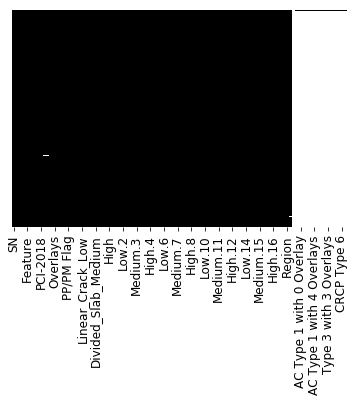

In [11]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='cubehelix')

Drop unnecssary information.

In [12]:
df1.columns.get_loc("ADT_avg")

81

In [13]:
df1.drop(df1.columns[17:80], axis=1, inplace=True)

In [14]:
df1.columns.get_loc("ADT_avg")

18

In [15]:
df1.drop(df1.columns[19:], axis=1, inplace=True)

In [16]:
list(df1.columns.values)

['SN',
 'County',
 'From_RP',
 'To_RP',
 'Feature',
 'Length',
 'PaveType',
 'Age',
 'PCI-2018',
 'RemL70',
 'RemL55',
 'IRI',
 'Overlays',
 'Best Value',
 'Low Cost',
 'CPR Flag',
 'PP/PM Flag',
 'Region',
 'ADT_avg']

In [17]:
df1.drop(['Best Value', 'Low Cost', 'CPR Flag', 'PP/PM Flag', 'Region',], axis=1,inplace=True)

The data contains some negative values for remaining life columns and there is also some values missing. I have chosen to replace all missing values with 0, except the columns for 'ADT_avg'. This column is using an interpolate to come up with the ADT's nearest and interpolate a volume.

In [18]:
df1['ADT_avg'] = df1['ADT_avg'].interpolate()

In [19]:
df1["ADT_avg"].value_counts().head()

750.0     51
1350.0    38
1770.0    31
1100.0    31
1010.0    31
Name: ADT_avg, dtype: int64

Check for null data once again.

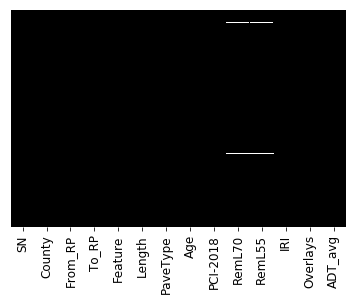

In [20]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='cubehelix')

In [21]:
df1 = df1.fillna(0)

# Explore and Visualize Data

The Revaining life values are determined by using the existing PCI and age data. these values are not going to help us make predictions, so I will drop them.

In [22]:
df1.drop(['RemL70', 'RemL55'], axis=1,inplace=True)

In [23]:
df1.describe()

SN        Length      PaveType           Age      PCI-2018  \
count   12953.000000  12953.000000  12953.000000  12953.000000  12953.000000   
mean    74803.251911      1.107724      2.968579     14.003629     71.593289   
std     53690.915021      0.333230      2.732745      8.942178     22.236613   
min        10.000000      0.120000      1.000000      1.000000      0.000000   
25%     35390.000000      0.930000      1.000000      7.000000     56.030000   
50%     70550.000000      1.040000      1.000000     13.000000     74.540000   
75%    105950.000000      1.300000      3.000000     19.000000     90.780000   
max    415000.000000      2.890000      8.000000     68.000000    100.000000   

                IRI      Overlays        ADT_avg  
count  12953.000000  12953.000000   12953.000000  
mean     103.178877      0.999382   11566.926233  
std       53.102322      1.144986   18012.457716  
min       25.000000      0.000000      90.000000  
25%       63.000000      0.000000    2470.000000  
50%       95.000000      1.000000    5110.000000  
75%      131.000000      2.000000   12690.000000  
max      432.000000      6.000000  173770.000000

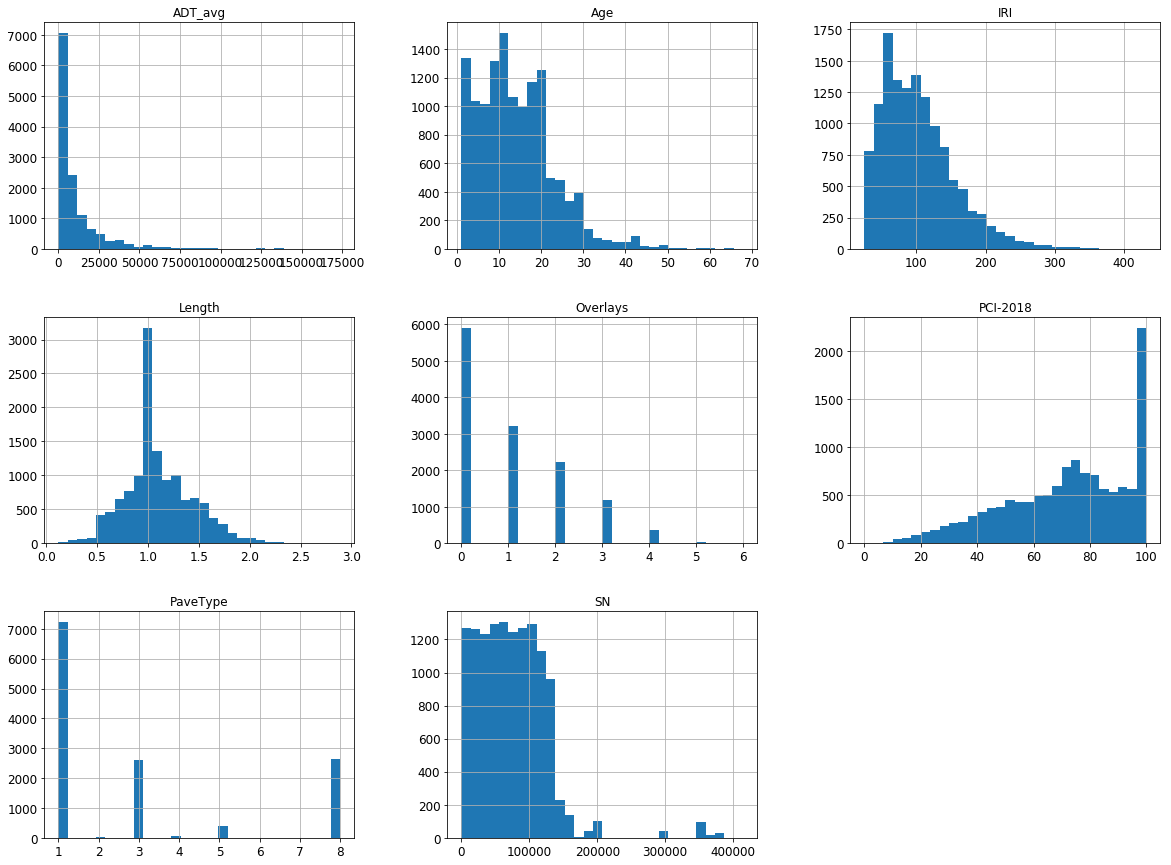

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
df1.hist(bins=30, figsize=(20,15))
plt.show()

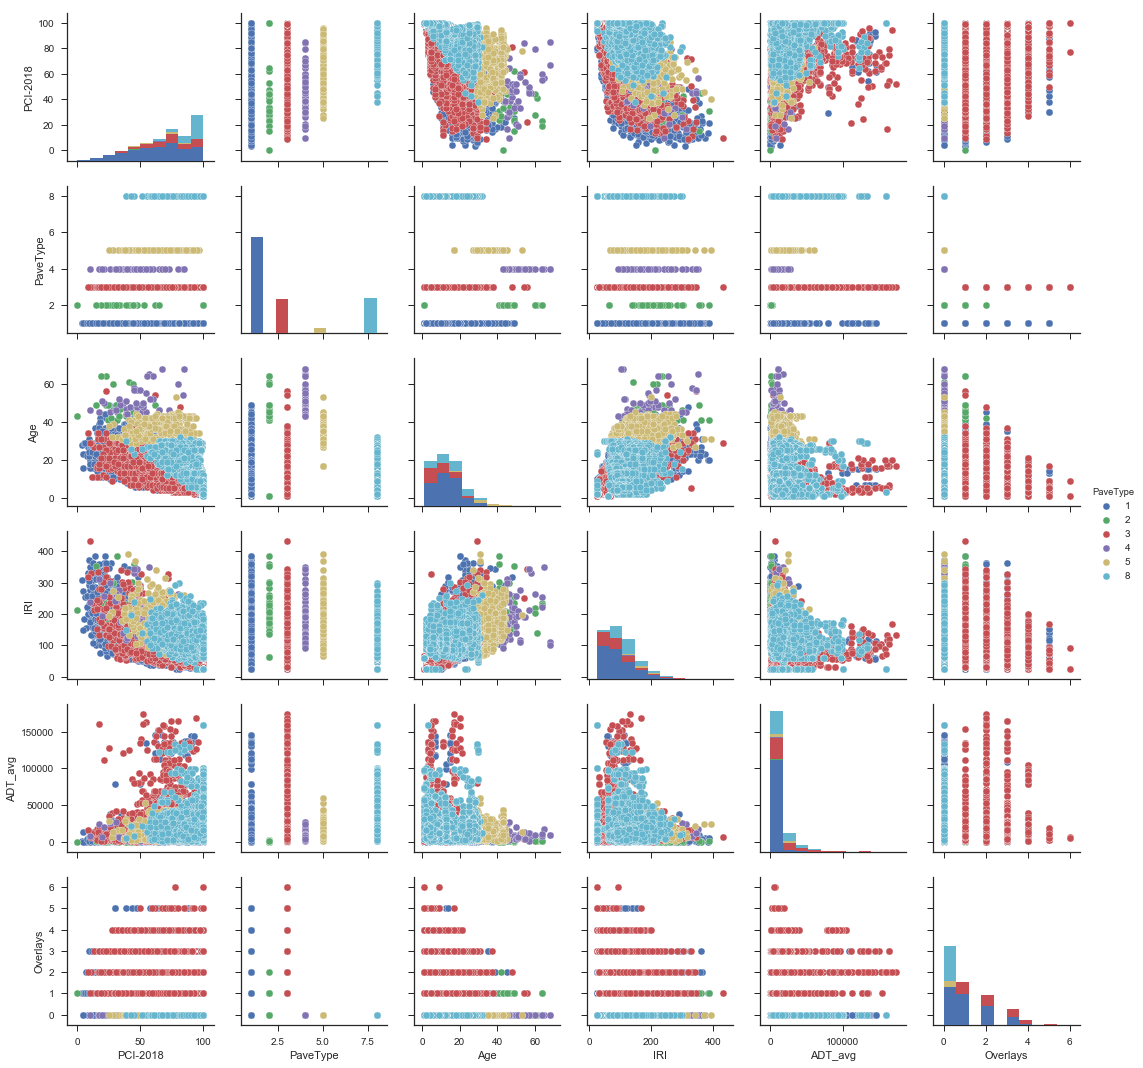

In [24]:
import seaborn as sns
sns.set(style="ticks")

attributes = ['PCI-2018','PaveType','Age','IRI', 'ADT_avg', 'Overlays']
sns.pairplot(df1[attributes], hue = "PaveType")

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

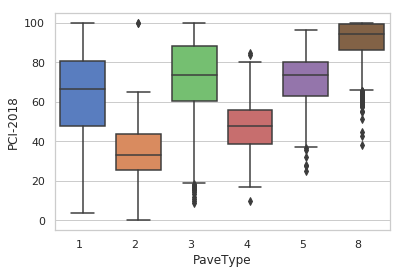

In [24]:
import seaborn as sns
sns.boxplot(x="PaveType", y="PCI-2018", data=df1)
plt.xticks(rotation=0,horizontalalignment='right')


KeyboardInterrupt



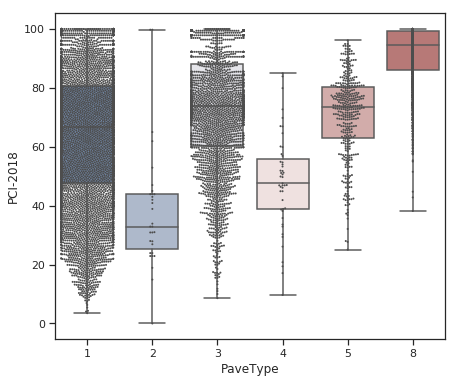

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 6))
#ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="PaveType", y="PCI-2018", data=df1,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="PaveType", y="PCI-2018", data=df1,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

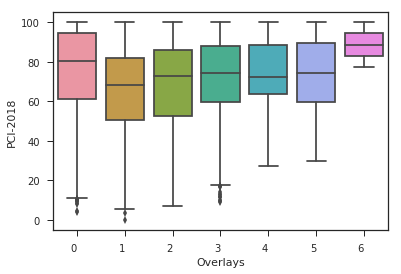

In [23]:
import seaborn as sns
sns.boxplot(x="Age", y="PCI-2018", data=df1)
plt.xticks(rotation=0,horizontalalignment='right')

In [ ]:
df1["PCI-2018"].value_counts().head()

(array([  24.,  187.,  441.,  720., 1066., 1314., 1595., 2401., 1809.,
        3396.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

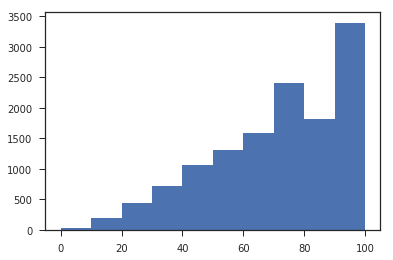

In [25]:
plt.hist(df1["PCI-2018"])

(array([3.656e+03, 4.013e+03, 3.007e+03, 1.324e+03, 6.030e+02, 2.130e+02,
        8.000e+01, 4.000e+01, 1.500e+01, 2.000e+00]),
 array([ 25. ,  65.7, 106.4, 147.1, 187.8, 228.5, 269.2, 309.9, 350.6,
        391.3, 432. ]),
 <a list of 10 Patch objects>)

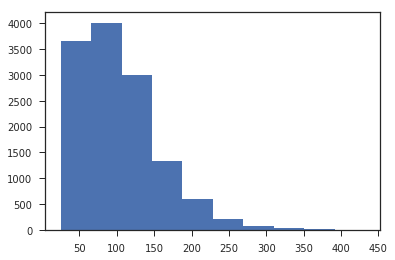

In [26]:
plt.hist(df1["IRI"])

Develop a correlation matrix and plot it to find out what the data looks like when paired with the higest correlated variables.

In [19]:
corr_matrix = df1.corr()
corr_matrix["PCI-2018"].sort_values(ascending=False)

PCI-2018      1.000000
PaveType      0.462079
ADT_avg       0.208744
SN            0.100708
PP/PM Flag    0.096283
Length        0.014788
Overlays     -0.067294
IRI          -0.500312
Age          -0.519874
Name: PCI-2018, dtype: float64

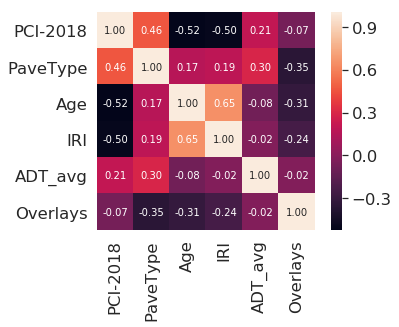

In [254]:
import numpy as np
attributes = ['PCI-2018','PaveType','Age','IRI', 'ADT_avg', 'Overlays']
cm = np.corrcoef(df1[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

Plot the top correlation plot, Age vs. PCI. 

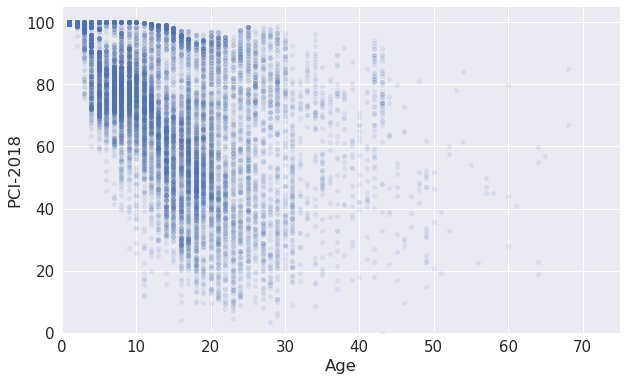

In [32]:
df1.plot(kind="scatter", x='Age', y="PCI-2018", alpha=0.1,figsize=(10,6))
plt.axis([0,75, 0, 105])
plt.show()

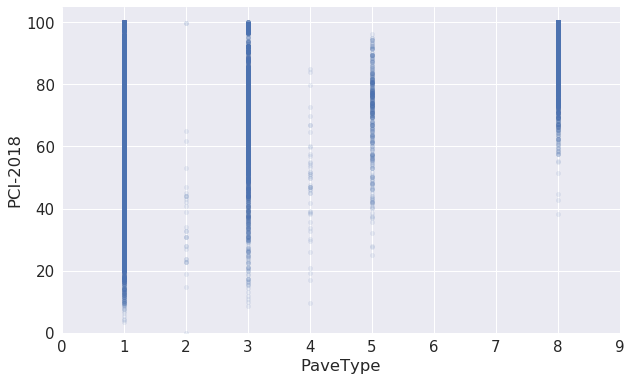

In [33]:
df1.plot(kind="scatter", x='PaveType', y="PCI-2018", alpha=0.1,figsize=(6,4))
plt.axis([0,9, 0, 105])
plt.show()

## Break out each pavement type and complete statistics for each

In [20]:
df1.PaveType.value_counts()

1    7225
8    2647
3    2607
5     396
4      47
2      31
Name: PaveType, dtype: int64

In [26]:
#Type 1's
#All Type 1's regardless of # overlays
Type1 = df1[df1.PaveType == 1]
#Type 1 with 0 overlays
Type1_0 = df1[(df1.PaveType == 1) & (df1.Overlays == 0)]
#Type 1 with 1 overlays
Type1_1 = df1[(df1.PaveType == 1) & (df1.Overlays == 1)]
#Type 1 with 2 overlays
Type1_2 = df1[(df1.PaveType == 1) & (df1.Overlays == 2)]
#Type 1 with 3+ overlays
Type1_3 = df1[(df1.PaveType == 1) & (df1.Overlays >= 3)]

#Type 2
Type2 = df1[df1.PaveType == 2]

#Type 3's
#All Type 3's regardless of # overlays
Type3 = df1[df1.PaveType == 3]
#Type 3 with 0 overlays
Type3_0 = df1[(df1.PaveType == 3) & (df1.Overlays == 0)]
#Type 3 with 1 overlays
Type3_1 = df1[(df1.PaveType == 3) & (df1.Overlays == 1)]
#Type 3 with 2 overlays
Type3_2 = df1[(df1.PaveType == 3) & (df1.Overlays == 2)]
#Type 3 with 3+ overlays
Type3_3 = df1[(df1.PaveType == 3) & (df1.Overlays >= 3)]

Type4 = df1[df1.PaveType == 4]
Type5 = df1[df1.PaveType == 5]
Type8 = df1[df1.PaveType == 8]

## Residual Plot of Each Pavement Type. 

The residplot() function can be a useful tool for checking whether the simple regression model is appropriate for a dataset. It fits and removes a simple linear regression and then plots the residual values for each observation. Ideally, these values should be randomly scattered around y = 0.
If there is structure in the residuals, it suggests that simple linear regression is not appropriate.

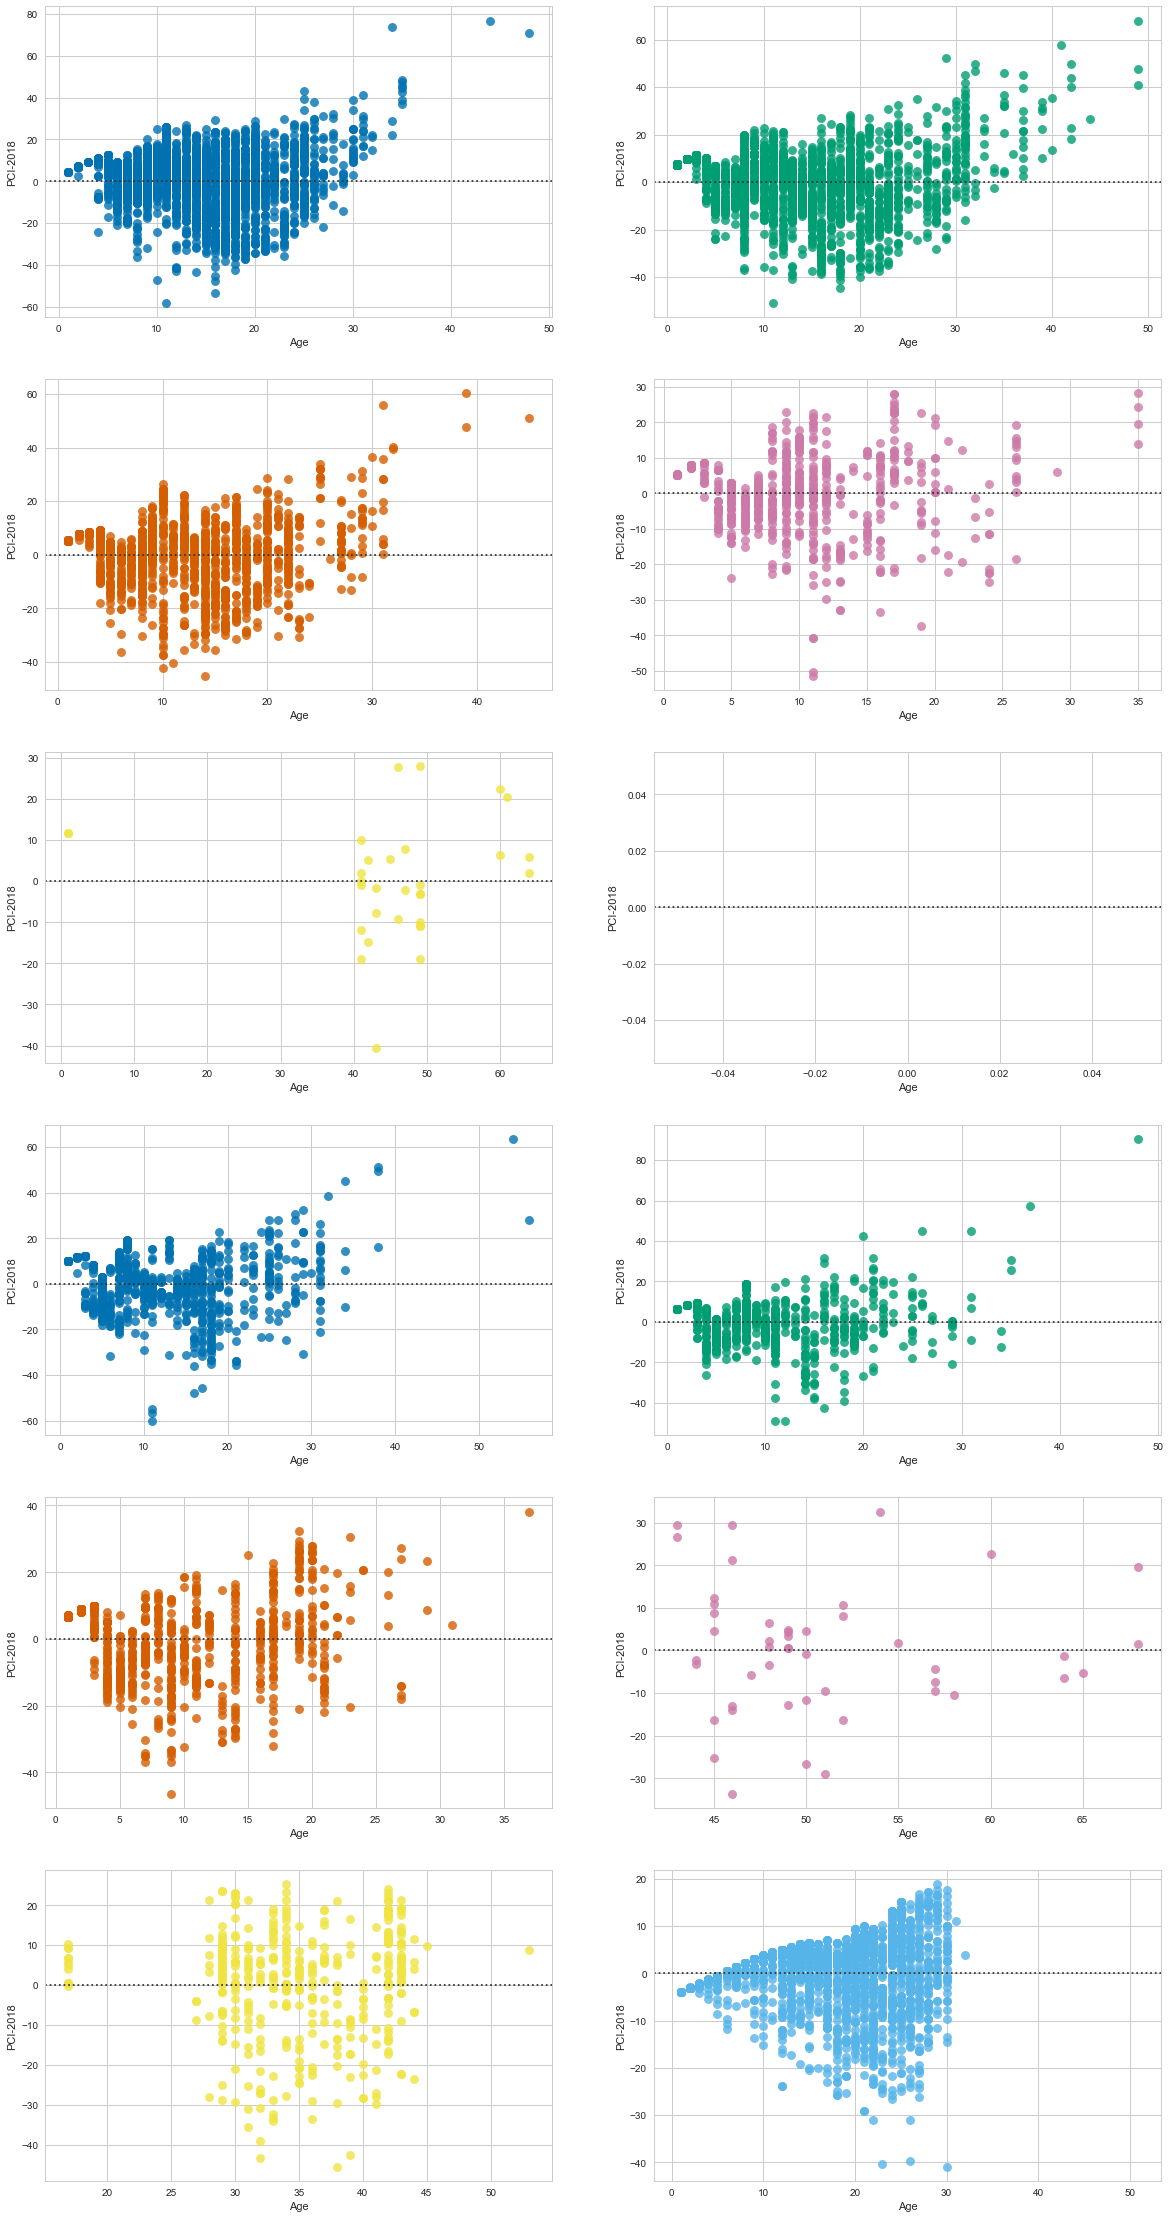

In [27]:
sns.set(style="whitegrid",palette="colorblind")
f, axes = plt.subplots(6,2, figsize=(20, 40), sharex=False)
sns.residplot(x="Age", y="PCI-2018", data=Type1_0, scatter_kws={"s": 80},ax=axes[0,0])
sns.residplot(x="Age", y="PCI-2018", data=Type1_1, scatter_kws={"s": 80},ax=axes[0,1])
sns.residplot(x="Age", y="PCI-2018", data=Type1_2, scatter_kws={"s": 80},ax=axes[1,0])
sns.residplot(x="Age", y="PCI-2018", data=Type1_3, scatter_kws={"s": 80},ax=axes[1,1])
sns.residplot(x="Age", y="PCI-2018", data=Type2, scatter_kws={"s": 80},ax=axes[2,0])
sns.residplot(x="Age", y="PCI-2018", data=Type3_0, scatter_kws={"s": 80},ax=axes[2,1])
sns.residplot(x="Age", y="PCI-2018", data=Type3_1, scatter_kws={"s": 80},ax=axes[3,0])
sns.residplot(x="Age", y="PCI-2018", data=Type3_2, scatter_kws={"s": 80},ax=axes[3,1])
sns.residplot(x="Age", y="PCI-2018", data=Type3_3, scatter_kws={"s": 80},ax=axes[4,0])
sns.residplot(x="Age", y="PCI-2018", data=Type4, scatter_kws={"s": 80},ax=axes[4,1])
sns.residplot(x="Age", y="PCI-2018", data=Type5, scatter_kws={"s": 80},ax=axes[5,0]);
sns.residplot(x="Age", y="PCI-2018", data=Type8, scatter_kws={"s": 80},ax=axes[5,1]);

We can see with these residual plots that a linear model may be appropriate for about the first 20 to 25 years in some of the pavement data (Type 1_0, Type 1_2, and Type 1_3). But we can see that as we continue beyond that, our tail of the residual plot increases in value. This indicates that the model (pavement condition) levels out and does not deteriorate as quickly as it did earlier in its life.

## Scatterplot of all data with pave type by color and ADT by size

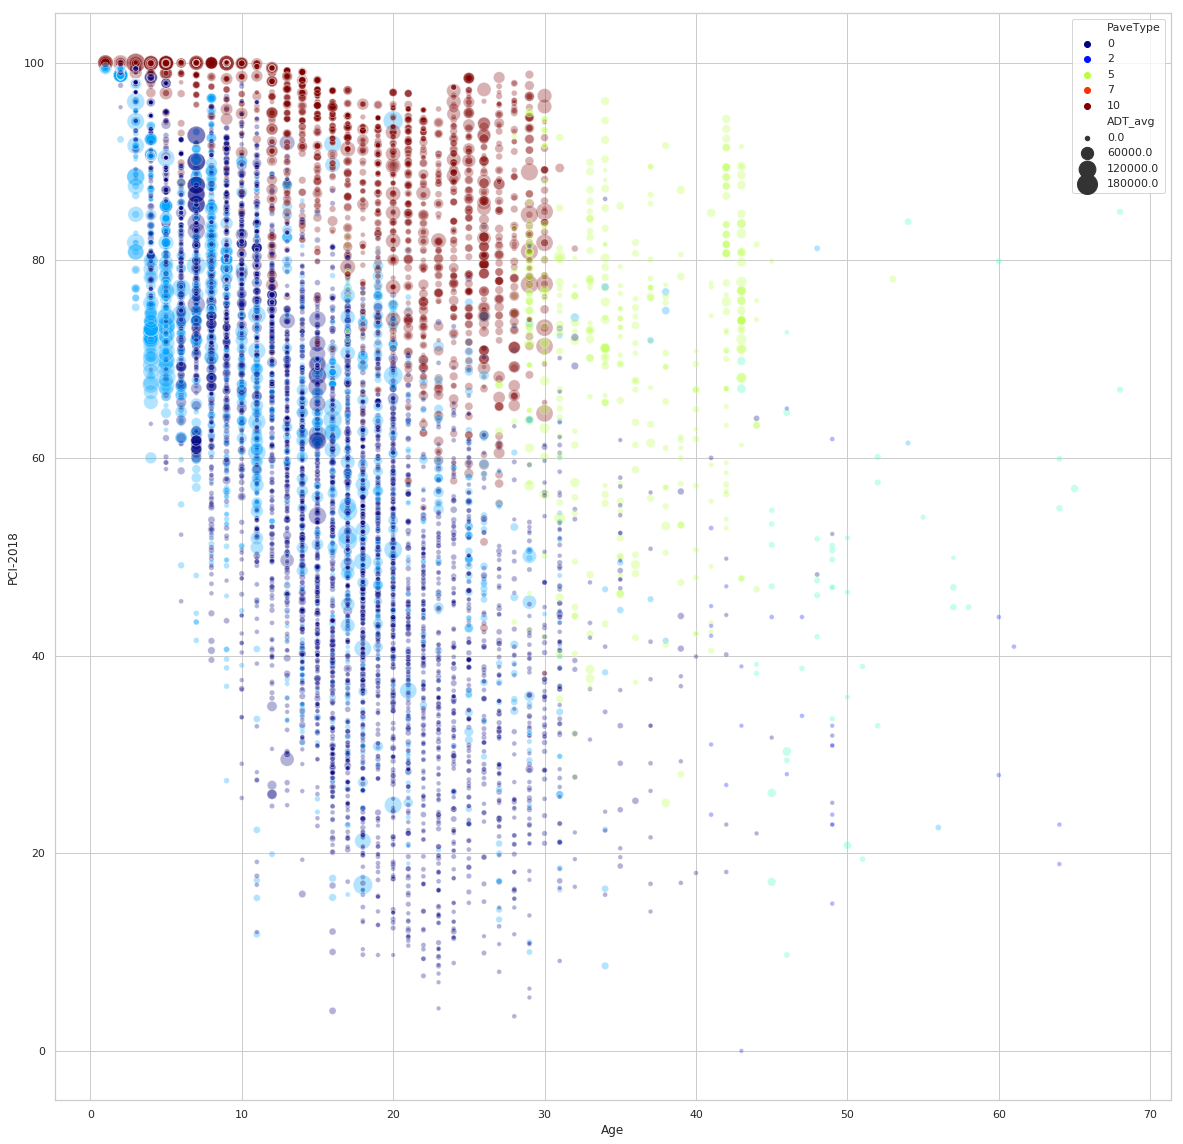

In [58]:
import seaborn as sns
sns.set(style="whitegrid")
f, axes = plt.subplots(1,1, figsize=(20, 20), sharex=False)
sns.scatterplot(x="Age", y="PCI-2018", hue="PaveType", size='ADT_avg', 
                palette="jet",alpha=.3,sizes=(20,400), data=df1)

## Scatterplot of all data with pave type by plot and ADT by size

AttributeError: module 'seaborn' has no attribute 'scatterplot'

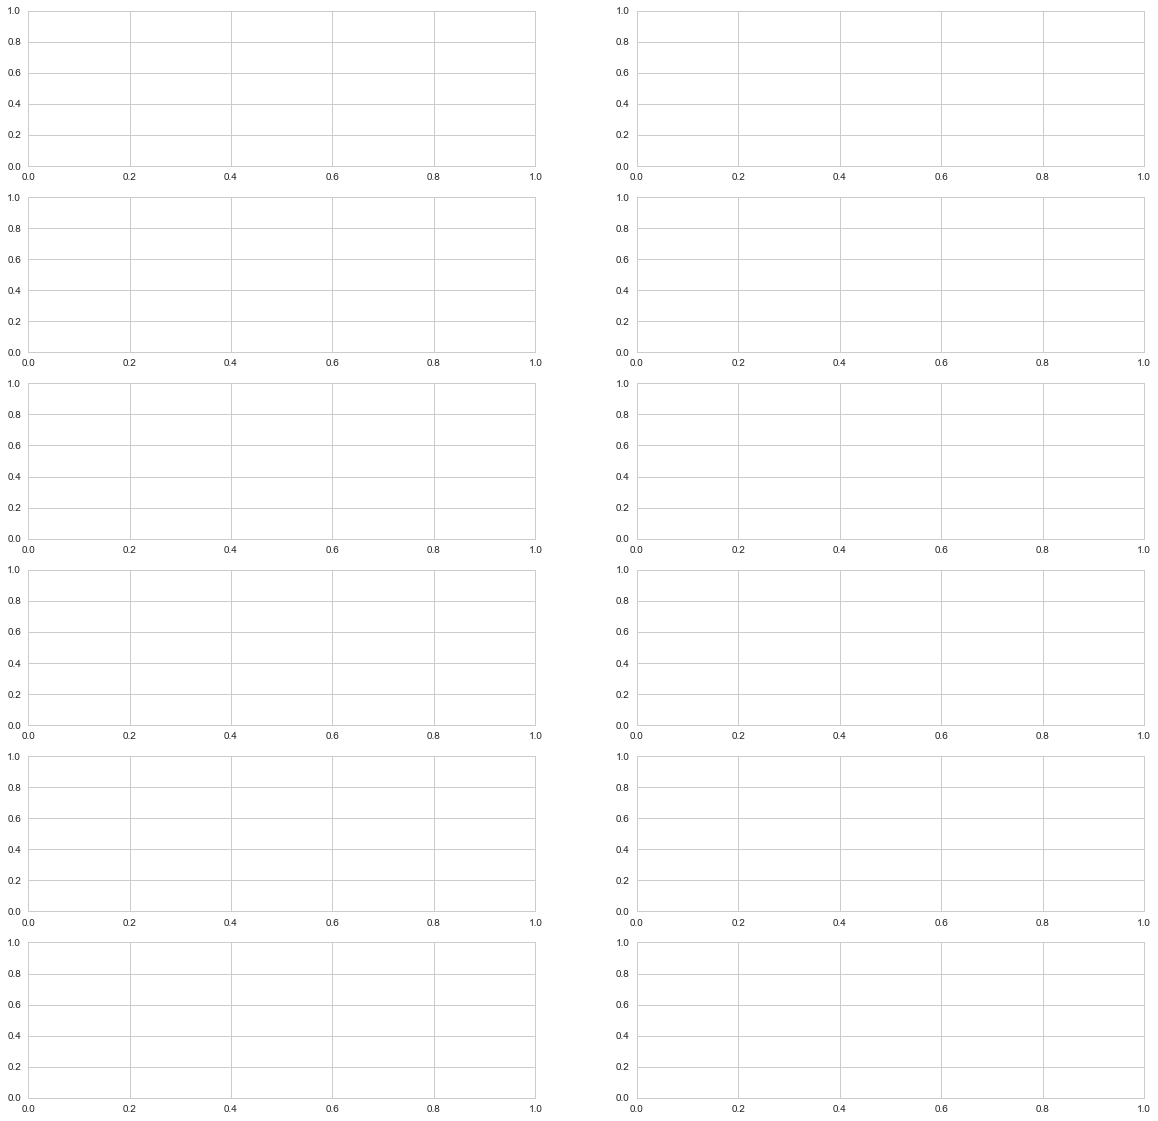

In [36]:
f, axes = plt.subplots(6,2, figsize=(20, 20), sharex=False)

sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_0, ax=axes[0,0] )
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_1, ax=axes[0,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_2, ax=axes[1,0])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_3, ax=axes[1,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type2, ax=axes[2,0] )
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type3_0, ax=axes[2,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type3_1, ax=axes[3,0])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type3_2, ax=axes[3,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type3_3, ax=axes[4,0])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type4, ax=axes[4,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type5, ax=axes[5,0])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type8, ax=axes[5,1])

## Swarmplot w/ Boxplot by Pave Type

'sns.boxplot(x="Age", y="PCI-2018", data=Type2, ax=axes[0,1])\nsns.boxplot(x="Age", y="PCI-2018", data=Type3, ax=axes[1,0])\nsns.boxplot(x="Age", y="PCI-2018", data=Type4, ax=axes[1,1])\nsns.boxplot(x="Age", y="PCI-2018", data=Type5, ax=axes[2,0])\nsns.boxplot(x="Age", y="PCI-2018", data=Type8, ax=axes[2,1])'

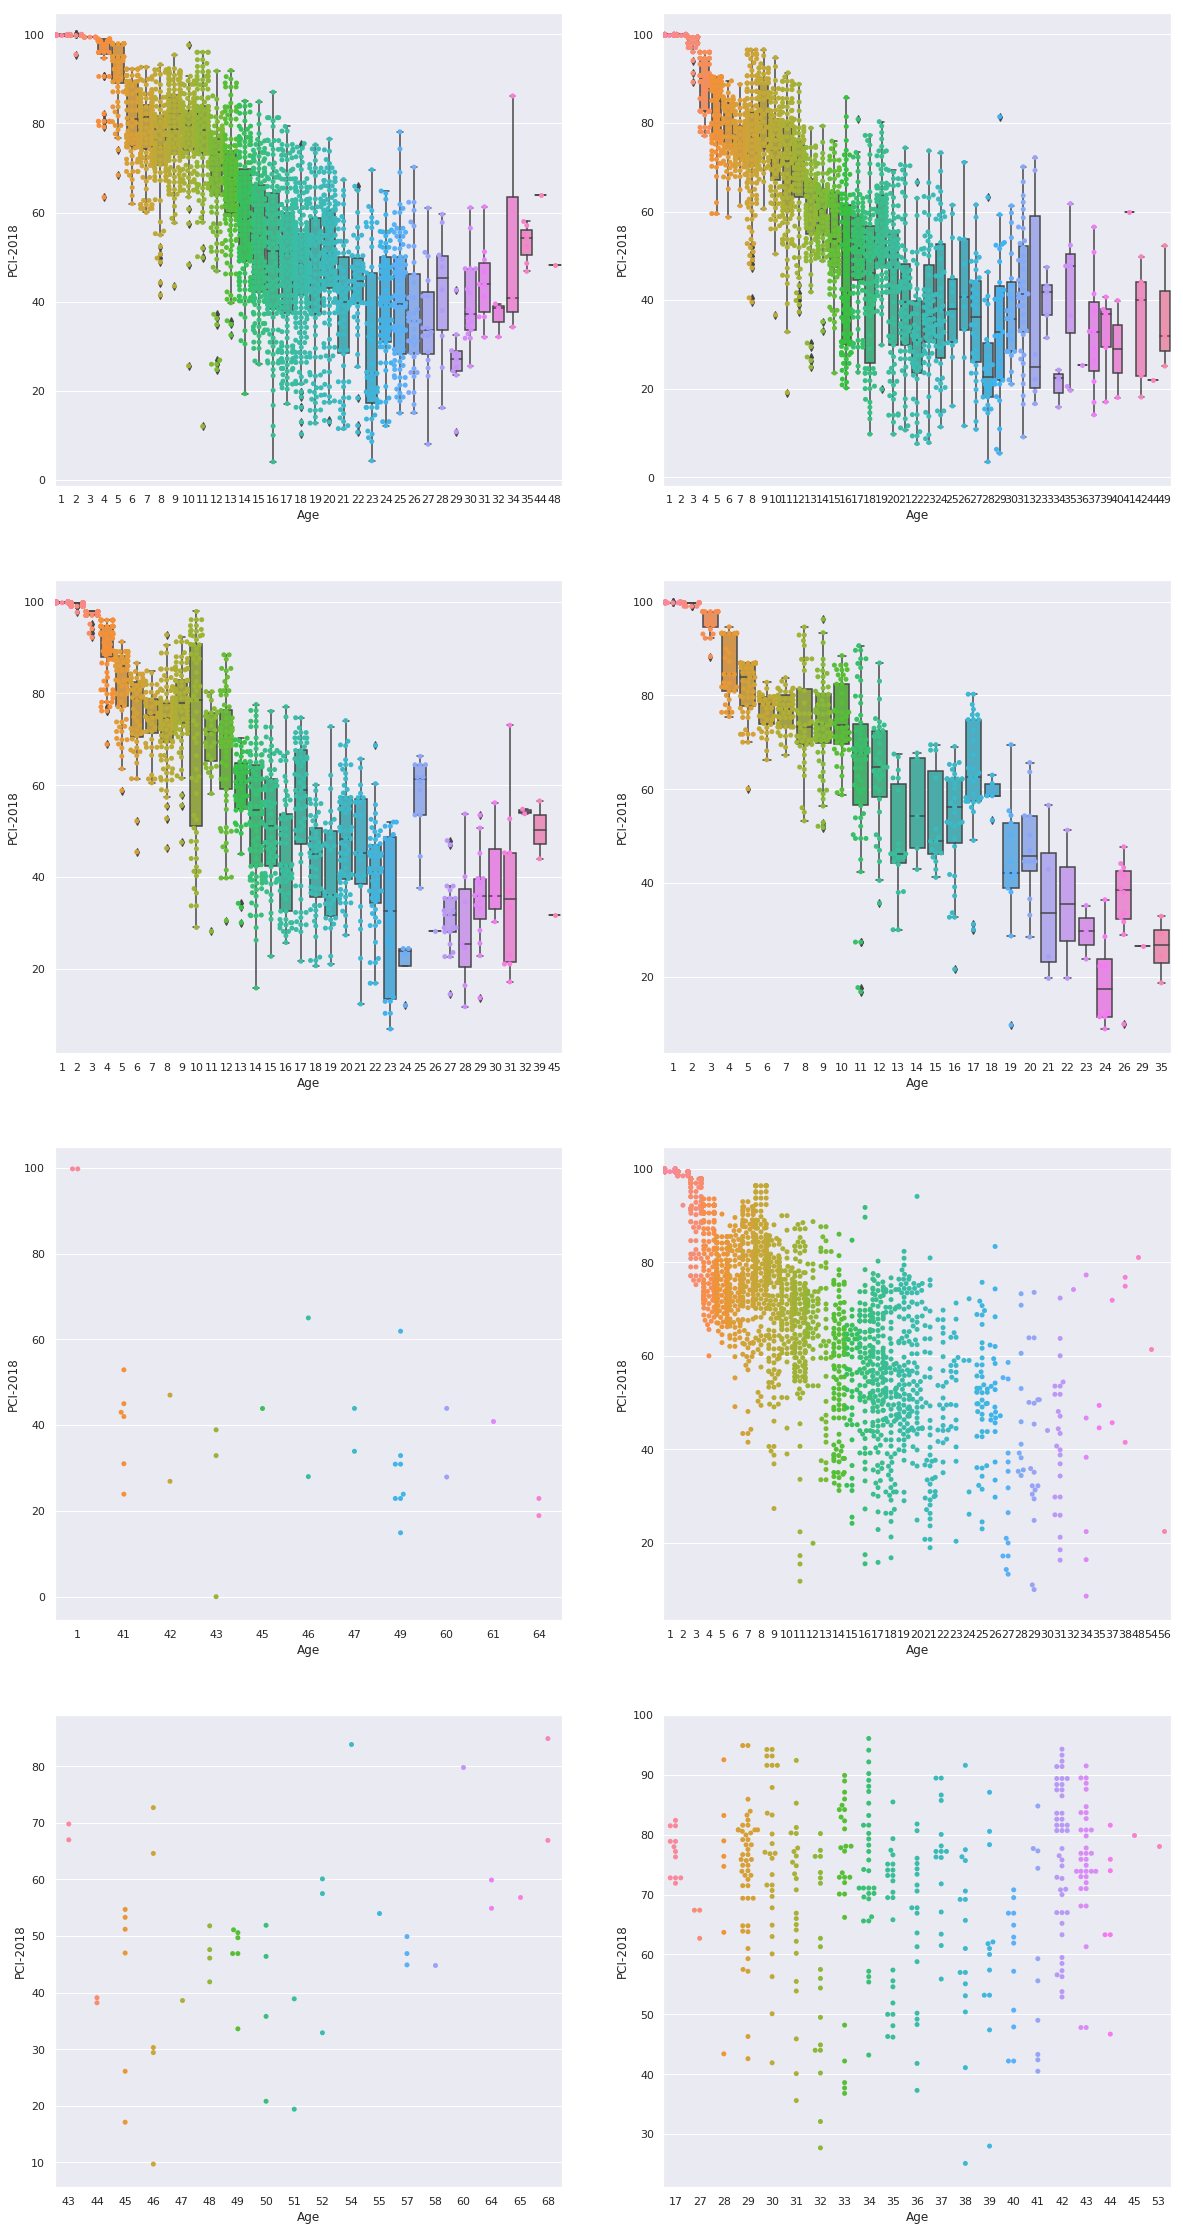

In [70]:
sns.set(style="darkgrid",palette="muted")
f, axes = plt.subplots(4,2, figsize=(20, 40), sharex=False)
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_0, ax=axes[0,0], edgecolor="black")
sns.boxplot(x="Age", y="PCI-2018", data=Type1_0, ax=axes[0,0])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_1, ax=axes[0,1])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_1, ax=axes[0,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_2, ax=axes[1,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_2, ax=axes[1,0])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_3, ax=axes[1,1])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_3, ax=axes[1,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type2, ax=axes[2,0])
sns.swarmplot(x="Age", y="PCI-2018", data=Type3, ax=axes[2,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type4, ax=axes[3,0])
sns.swarmplot(x="Age", y="PCI-2018", data=Type5, ax=axes[3,1])

"""sns.boxplot(x="Age", y="PCI-2018", data=Type2, ax=axes[0,1])
sns.boxplot(x="Age", y="PCI-2018", data=Type3, ax=axes[1,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type4, ax=axes[1,1])
sns.boxplot(x="Age", y="PCI-2018", data=Type5, ax=axes[2,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type8, ax=axes[2,1])"""

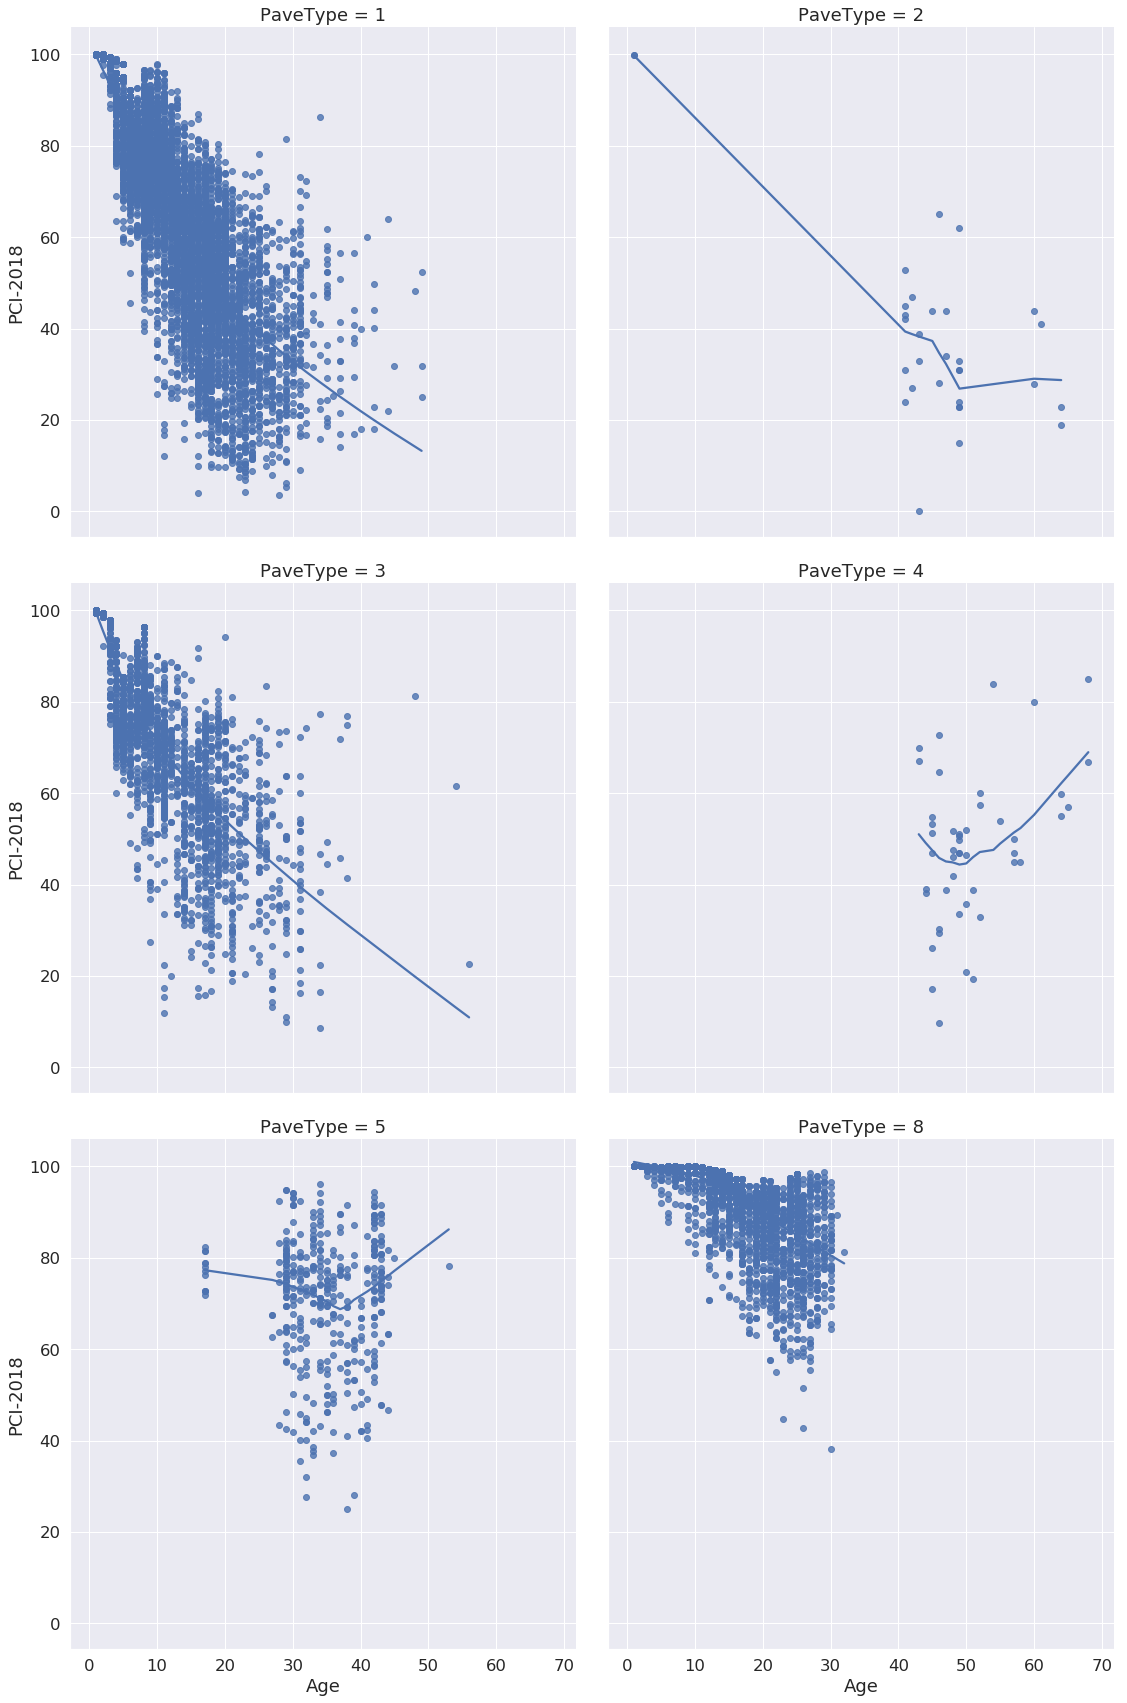

In [79]:
sns.lmplot(x="Age", y="PCI-2018", col="PaveType", data=df1,lowess=True,truncate=True, 
           col_wrap=2, height=8);

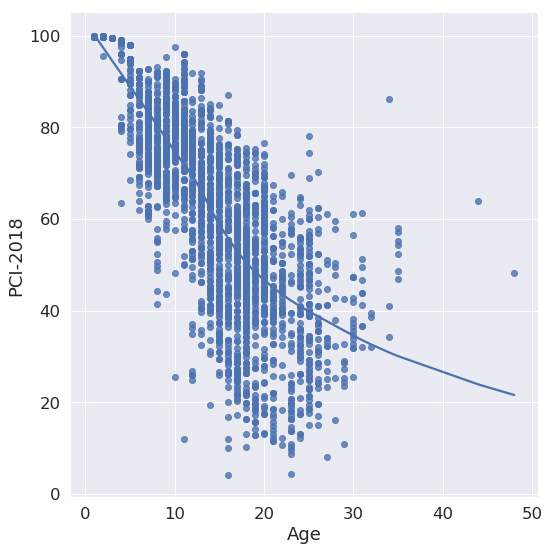

In [80]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_0,
           lowess=True, height=8);

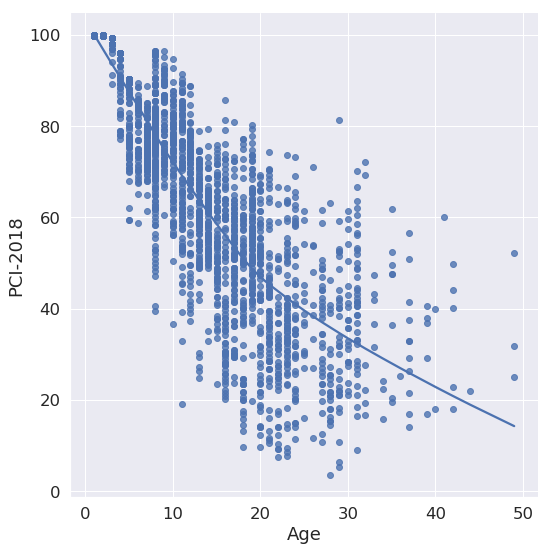

In [85]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_1,
           lowess=True, height=8);

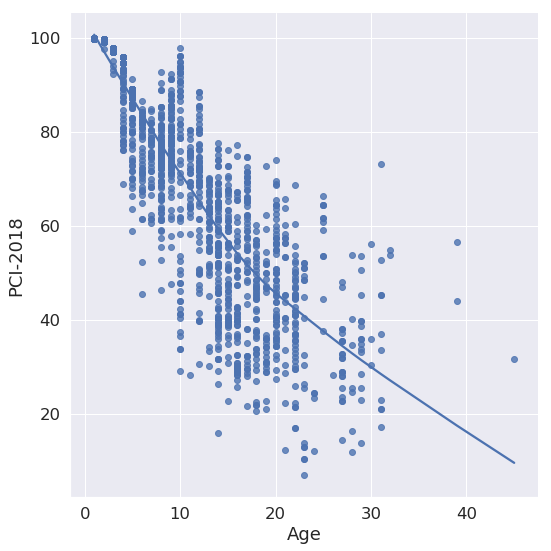

In [82]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_2,
           lowess=True, height=8);

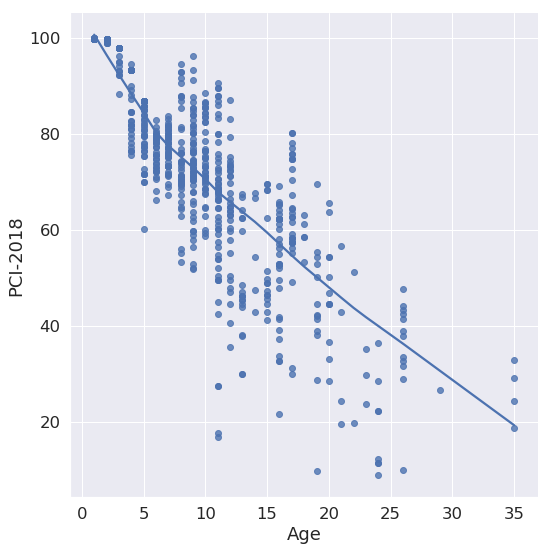

In [83]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_3,
           lowess=True, height=8);

## Linear and Polynomial Regression of Type 1 Pavement

In [20]:
Type1_0 = Type1_0[['PCI-2018','PaveType','Age','IRI']]
Type1_1 = Type1_1[['PCI-2018','PaveType','Age','IRI']]
Type1_2 = Type1_2[['PCI-2018','PaveType','Age','IRI']]
Type1_3 = Type1_3[['PCI-2018','PaveType','Age','IRI']]

In [26]:
#Type1_0
from sklearn.model_selection import train_test_split

X1_0 = Type1_0['Age'].values
X1_0 = np.resize(X1_0,(len(X1_0),1))
y1_0 = Type1_0['PCI-2018'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X1_0.shape, y1_0.shape)
#Type1_1
X1_1 = Type1_1['Age'].values
X1_1 = np.resize(X1_1,(len(X1_1),1))
y1_1 = Type1_1['PCI-2018'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X1_1.shape, y1_1.shape)
#Type1_2
X1_2 = Type1_2['Age'].values
X1_2 = np.resize(X1_2,(len(X1_2),1))
y1_2 = Type1_2['PCI-2018'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X1_2.shape, y1_2.shape)
#Type1_3
X1_3 = Type1_3['Age'].values
X1_3 = np.resize(X1_3,(len(X1_3),1))
y1_3 = Type1_3['PCI-2018'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X1_3.shape, y1_3.shape)

(2816, 1) (2816,)
(2300, 1) (2300,)
(1433, 1) (1433,)
(676, 1) (676,)


In [25]:
#print ("X_train", X_train.shape, "y_train", y_train.shape)
#print ("X_test", X_test.shape, "y_test", y_test.shape)

### Type 1 Pavement with 0 overlays

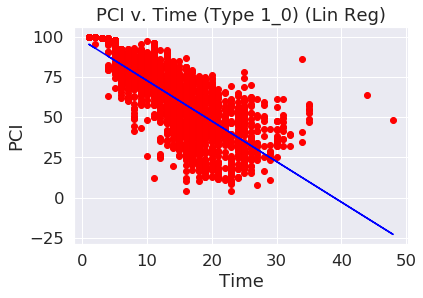

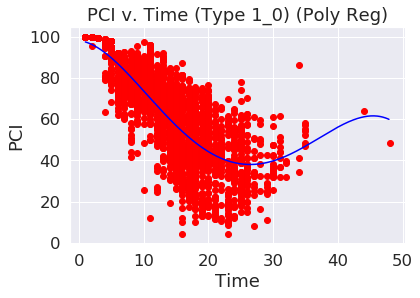

In [259]:
# Basic Polynomial Regression model using PCI and pavement age

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X1_0, y1_0)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 7)
X1_0_poly = poly_reg.fit_transform(X1_0)
poly_reg.fit(X1_0_poly, y1_0)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X1_0_poly, y1_0)

# Visualising the Linear Regression results
plt.scatter(X1_0, y1_0, color = 'red')
plt.plot(X1_0, lin_reg.predict(X1_0), color = 'blue')
plt.title('PCI v. Time (Type 1_0) (Lin Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()

"""# Visualising the Polynomial Regression results
plt.scatter(X1_0, y1_0, color = 'red')
plt.plot(X1_0, lin_reg_2.predict(poly_reg.fit_transform(X1_0)), color = 'blue')
plt.title('PCI v. Time (Type 1_0) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()
"""
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X1_0), max(X1_0), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X1_0, y1_0, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('PCI v. Time (Type 1_0) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()


In [ ]:
# Scipy optimize curve fit example
# sigma = numpy.array([1.0,1.0,1.0,1.0,1.0])
# initial guess
# x0 = numpy.array([0.0,0.0,0.0)])

# def func(x, b, c)
#    return a + b*x + c*x*x
# import scipy.optimize as optimization
# print optimization.curve_fit(func, xdata, ydata, x0, sigma

In [260]:
# Predicting a new result with Linear Regression
#for i in range(50):
    #print("Time = ", i, lin_reg.predict(i))

# Predicting a new result with Polynomial Regression
for i in range(50):
    print("Time = ", i, lin_reg_2.predict(poly_reg.fit_transform(i)))

Time =  0 [98.143]
Time =  1 [97.494]
Time =  2 [96.26]
Time =  3 [94.517]
Time =  4 [92.337]
Time =  5 [89.79]
Time =  6 [86.942]
Time =  7 [83.855]
Time =  8 [80.588]
Time =  9 [77.198]
Time =  10 [73.736]
Time =  11 [70.251]
Time =  12 [66.789]
Time =  13 [63.391]
Time =  14 [60.097]
Time =  15 [56.942]
Time =  16 [53.956]
Time =  17 [51.17]
Time =  18 [48.607]
Time =  19 [46.289]
Time =  20 [44.235]
Time =  21 [42.458]
Time =  22 [40.971]
Time =  23 [39.781]
Time =  24 [38.893]
Time =  25 [38.308]
Time =  26 [38.023]
Time =  27 [38.032]
Time =  28 [38.327]
Time =  29 [38.895]
Time =  30 [39.719]
Time =  31 [40.781]
Time =  32 [42.057]
Time =  33 [43.522]
Time =  34 [45.145]
Time =  35 [46.893]
Time =  36 [48.73]
Time =  37 [50.617]
Time =  38 [52.508]
Time =  39 [54.359]
Time =  40 [56.119]
Time =  41 [57.733]
Time =  42 [59.146]
Time =  43 [60.297]
Time =  44 [61.121]
Time =  45 [61.552]
Time =  46 [61.519]
Time =  47 [60.947]
Time =  48 [59.761]
Time =  49 [57.877]


### Type 1 Pavement with 1 overlay

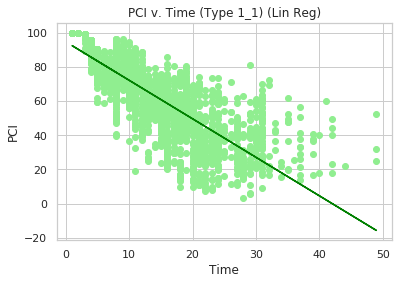

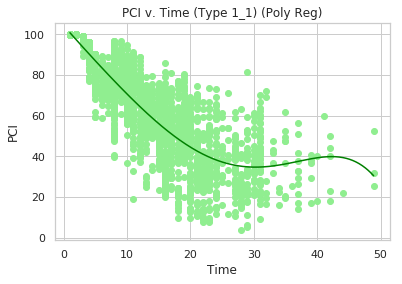

In [122]:
# Basic Polynomial Regression model using PCI and pavement age

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X1_1, y1_1)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 5)
X1_1_poly = poly_reg.fit_transform(X1_1)
poly_reg.fit(X1_1_poly, y1_1)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X1_1_poly, y1_1)

# Visualising the Linear Regression results
plt.scatter(X1_1, y1_1, color = 'lightgreen')
plt.plot(X1_1, lin_reg.predict(X1_1), color = 'green')
plt.title('PCI v. Time (Type 1_1) (Lin Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()

"""# Visualising the Polynomial Regression results
plt.scatter(X1_1, y1_1, color = 'lightgreen')
plt.plot(X1_1, lin_reg_2.predict(poly_reg.fit_transform(X1_1)), color = 'green')
plt.title('PCI v. Time (Type 1_1) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()
"""
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X1_1), max(X1_1), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X1_1, y1_1, color = 'lightgreen')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'green')
plt.title('PCI v. Time (Type 1_1) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()


In [121]:
# Predicting a new result with Linear Regression
#for i in range(50):
    #print("Time = ", i, lin_reg.predict(i))

# Predicting a new result with Polynomial Regression
for i in range(50):
    print("Time = ", i, lin_reg_2.predict(poly_reg.fit_transform(i)))

Time =  0 [104.43629201]
Time =  1 [101.41426856]
Time =  2 [97.61303505]
Time =  3 [93.58049993]
Time =  4 [89.64047455]
Time =  5 [85.95388518]
Time =  6 [82.56901078]
Time =  7 [79.46193802]
Time =  8 [76.56836439]
Time =  9 [73.80782037]
Time =  10 [71.10132065]
Time =  11 [68.38339464]
Time =  12 [65.6093856]
Time =  13 [62.75884786]
Time =  14 [59.83581072]
Time =  15 [56.8666178]
Time =  16 [53.89598967]
Time =  17 [50.98189788]
Time =  18 [48.1897774]
Time =  19 [45.58654481]
Time =  20 [43.23482881]
Time =  21 [41.1877593]
Time =  22 [39.48460103]
Time =  23 [38.14745746]
Time =  24 [37.17920989]
Time =  25 [36.56279691]
Time =  26 [36.26187847]
Time =  27 [36.22286882]
Time =  28 [36.37826204]
Time =  29 [36.65111355]
Time =  30 [36.96048067]
Time =  31 [37.22756478]
Time =  32 [37.38223764]
Time =  33 [37.36957344]
Time =  34 [37.15594856]
Time =  35 [36.73420992]
Time =  36 [36.12735294]
Time =  37 [35.39008962]
Time =  38 [34.60762673]
Time =  39 [33.89091393]
Time =  40 [

## Type 1 Pavement with 2 overlays

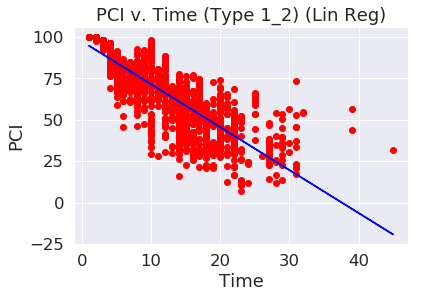

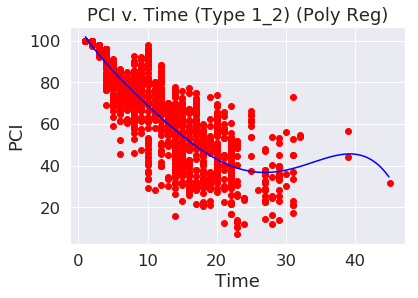

In [262]:
# Basic Polynomial Regression model using PCI and pavement age

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X1_2, y1_2)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 6)
X1_2_poly = poly_reg.fit_transform(X1_2)
poly_reg.fit(X1_2_poly, y1_2)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X1_2_poly, y1_2)

# Visualising the Linear Regression results
plt.scatter(X1_2, y1_2, color = 'red')
plt.plot(X1_2, lin_reg.predict(X1_2), color = 'blue')
plt.title('PCI v. Time (Type 1_2) (Lin Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()

"""# Visualising the Polynomial Regression results
plt.scatter(X1_0, y1_0, color = 'red')
plt.plot(X1_0, lin_reg_2.predict(poly_reg.fit_transform(X1_0)), color = 'blue')
plt.title('PCI v. Time (Type 1_0) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()
"""
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X1_2), max(X1_2), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X1_2, y1_2, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('PCI v. Time (Type 1_2) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()


In [263]:
# Predicting a new result with Linear Regression
#for i in range(50):
    #print("Time = ", i, lin_reg.predict(i))

# Predicting a new result with Polynomial Regression
for i in range(50):
    print("Time = ", i, lin_reg_2.predict(poly_reg.fit_transform(i)))

Time =  0 [106.995]
Time =  1 [101.96]
Time =  2 [97.382]
Time =  3 [93.168]
Time =  4 [89.24]
Time =  5 [85.535]
Time =  6 [82.]
Time =  7 [78.597]
Time =  8 [75.298]
Time =  9 [72.082]
Time =  10 [68.94]
Time =  11 [65.867]
Time =  12 [62.865]
Time =  13 [59.944]
Time =  14 [57.114]
Time =  15 [54.392]
Time =  16 [51.795]
Time =  17 [49.342]
Time =  18 [47.056]
Time =  19 [44.954]
Time =  20 [43.059]
Time =  21 [41.386]
Time =  22 [39.954]
Time =  23 [38.773]
Time =  24 [37.856]
Time =  25 [37.206]
Time =  26 [36.825]
Time =  27 [36.709]
Time =  28 [36.849]
Time =  29 [37.228]
Time =  30 [37.824]
Time =  31 [38.608]
Time =  32 [39.543]
Time =  33 [40.586]
Time =  34 [41.685]
Time =  35 [42.779]
Time =  36 [43.801]
Time =  37 [44.673]
Time =  38 [45.31]
Time =  39 [45.616]
Time =  40 [45.49]
Time =  41 [44.818]
Time =  42 [43.48]
Time =  43 [41.344]
Time =  44 [38.272]
Time =  45 [34.116]
Time =  46 [28.718]
Time =  47 [21.913]
Time =  48 [13.527]
Time =  49 [3.377]


### Type 1 Pavement with 3+ overlays

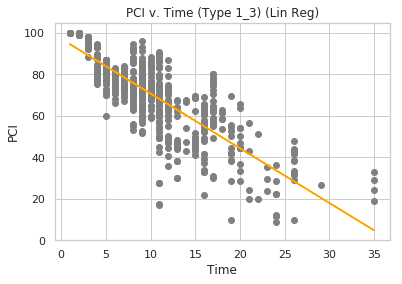

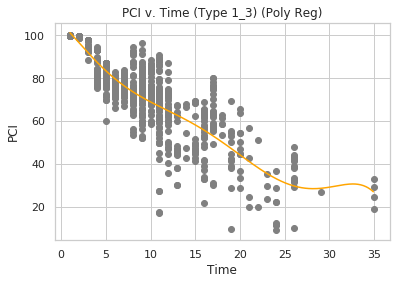

In [43]:
# Basic Polynomial Regression model using PCI and pavement age

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X1_3, y1_3)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 6)
X1_3_poly = poly_reg.fit_transform(X1_3)
poly_reg.fit(X1_3_poly, y1_3)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X1_3_poly, y1_3)

# Visualising the Linear Regression results
plt.scatter(X1_3, y1_3, color = 'grey')
plt.plot(X1_3, lin_reg.predict(X1_3), color = 'orange')
plt.title('PCI v. Time (Type 1_3) (Lin Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()

"""# Visualising the Polynomial Regression results
plt.scatter(X1_3, y1_3, color = 'red')
plt.plot(X1_3, lin_reg_2.predict(poly_reg.fit_transform(X1_3)), color = 'blue')
plt.title('PCI v. Time (Type 1_3) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()
"""
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(X1_3), max(X1_3), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X1_3, y1_3, color = 'grey')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'orange')
plt.title('PCI v. Time (Type 1_3) (Poly Reg)')
plt.xlabel('Time')
plt.ylabel('PCI')
plt.show()


In [49]:
# Predicting a new result with Linear Regression
#for i in range(50):
    #print("Time = ", i, lin_reg.predict(i))

# Predicting a new result with Polynomial Regression
for i in range(36):
    print("Time = ", i, lin_reg_2.predict(poly_reg.fit_transform(i)))

Time =  0 [105.46400783]
Time =  1 [101.23747482]
Time =  2 [96.63816486]
Time =  3 [92.00733301]
Time =  4 [87.57785726]
Time =  5 [83.4924253]
Time =  6 [79.82038313]
Time =  7 [76.57324551]
Time =  8 [73.71886821]
Time =  9 [71.19428202]
Time =  10 [68.91718863]
Time =  11 [66.79611836]
Time =  12 [64.73924959]
Time =  13 [62.66189013]
Time =  14 [60.49262029]
Time =  15 [58.17809787]
Time =  16 [55.68652489]
Time =  17 [53.00977617]
Time =  18 [50.16418969]
Time =  19 [47.19001882]
Time =  20 [44.14954632]
Time =  21 [41.12386015]
Time =  22 [38.20829113]
Time =  23 [35.50651241]
Time =  24 [33.1233007]
Time =  25 [31.15595938]
Time =  26 [29.68440339]
Time =  27 [28.75990596]
Time =  28 [28.39250711]
Time =  29 [28.53708402]
Time =  30 [29.07808316]
Time =  31 [29.81291429]
Time =  32 [30.43400621]
Time =  33 [30.50952439]
Time =  34 [29.46275036]
Time =  35 [26.55012296]


# Add in 2017 Data to see if there is any differences

In [101]:
import pandas as pd
Inventory="State_2017_PMDSS_Data.csv"
df2 = pd.read_csv(Inventory,low_memory=False)

In [102]:
df2.head()

SN Region   County Highway  From_RP    To_RP         Feature  Length  \
0  10     NW  DOUGLAS    002E  001G000  004H000  MINN/WIS ST LN    1.50   
1  30     NW  DOUGLAS    002E  004H000  007 000       BELNAP ST    1.50   
2  40     NW  DOUGLAS    002E  007 000  008M000      CATLIN AVE    0.94   
3  50     NW  DOUGLAS    002E  008M000  008M108         USH 53N    1.08   
4  80     NW  DOUGLAS    002E  008M108  010K008        18TH AVE    0.95   

   PaveType  Age     ...      Unnamed: 86  Unnamed: 87  Unnamed: 88  \
0         8    3     ...              NaN          NaN          NaN   
1         5   30     ...              NaN          NaN          NaN   
2         5   30     ...              NaN          NaN          NaN   
3         8   28     ...              NaN          NaN          NaN   
4         8   28     ...              NaN          NaN          NaN   

   Unnamed: 89  Unnamed: 90  Unnamed: 91  Unnamed: 92 Unnamed: 93 Unnamed: 94  \
0          NaN          NaN          NaN          NaN         NaN         NaN   
1          NaN          NaN          NaN          NaN         NaN         NaN   
2          NaN          NaN          NaN          NaN         NaN         NaN   
3          NaN          NaN          NaN          NaN         NaN         NaN   
4          NaN          NaN          NaN          NaN         NaN         NaN   

  Unnamed: 95  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 96 columns]

Drop unnecssary information.

In [103]:
df2.columns.get_loc("ADT_avg")

84

In [104]:
df2.drop(df2.columns[17:84], axis=1, inplace=True)

In [105]:
df2.columns.get_loc("ADT_avg")

17

In [106]:
df2.drop(df2.columns[18:], axis=1, inplace=True)

In [107]:
list(df2.columns.values)

['SN',
 'Region',
 'County',
 'Highway',
 'From_RP',
 'To_RP',
 'Feature',
 'Length',
 'PaveType',
 'Age',
 'PCI',
 'RemL70',
 'RemL55',
 'IRI',
 'OrigDate',
 'OrigType',
 'Overlays',
 'ADT_avg']

In [108]:
df2.drop(['OrigDate','OrigType', 'Region',], axis=1,inplace=True)

In [109]:
df2.describe()

SN        Length      PaveType           Age           PCI  \
count   12950.000000  12950.000000  12950.000000  12950.000000  12950.000000   
mean    74784.835676      1.109130      2.978842     13.762703     72.661799   
std     53690.292175      0.333401      2.740060      8.834313     21.506344   
min        10.000000      0.120000      1.000000      1.000000      0.000000   
25%     35382.500000      0.930000      1.000000      7.000000     58.200000   
50%     70545.000000      1.040000      1.000000     13.000000     76.000000   
75%    105937.500000      1.300000      3.000000     19.000000     90.900000   
max    415000.000000      2.890000      8.000000     67.000000    100.000000   

             RemL70        RemL55           IRI     Overlays       ADT_avg  
count  12869.000000  12869.000000  12950.000000  9147.000000  12950.000000  
mean       4.323895     10.809099    104.838378     1.236252   7199.497066  
std       13.029682     16.296474     54.125150     1.175524   8749.390431  
min      -54.000000    -48.000000     23.000000     0.000000      0.000000  
25%       -2.800000      0.800000     64.000000     0.000000   2434.000000  
50%        2.300000      6.500000     97.000000     1.000000   4745.000000  
75%        9.300000     14.300000    133.000000     2.000000   8430.000000  
max       80.000000     80.000000    449.000000     6.000000  86885.000000

The data contains some negative values for remaining life columns and there is also some values missing. I have chosen to replace all missing values with 0, except the columns for 'ADT_avg'. This column is using an interpolate to come up with the ADT's nearest and interpolate a volume.

In [110]:
df2.rename(columns={'PCI': 'PCI-2018'}, inplace=True)

In [111]:
df2.drop(['RemL70', 'RemL55'], axis=1,inplace=True)

In [112]:
df2["ADT_avg"].value_counts().head()

0       78
750     64
1770    37
660     36
1100    34
Name: ADT_avg, dtype: int64

In [113]:
df2['ADT_avg'] = df2['ADT_avg'].interpolate()

In [114]:
df2 = df2.fillna(0)

In [115]:
df_new = pd.concat([df1, df2])
df_new

ADT_avg  Age       County              Feature      From_RP Highway  \
0      17830.0    4      DOUGLAS       MINN/WIS ST LN  002E001G000     NaN   
1      14031.0    1      DOUGLAS            BELNAP ST  002E004H000     NaN   
2       8593.0    1      DOUGLAS           CATLIN AVE  002E007 000     NaN   
3      20724.0   29      DOUGLAS              USH 53N  002E008M000     NaN   
4      20127.0   29      DOUGLAS             18TH AVE  002E008M108     NaN   
5      21542.0   29      DOUGLAS             28TH AVE  002E010K008     NaN   
6      24847.0   29      DOUGLAS           37TH AVE E  002E010K094     NaN   
7      17741.0   29      DOUGLAS           48TH AVE E  002E012K000     NaN   
8      15410.0   17      DOUGLAS     MOCCASIN MIKE RD  002E014A000     NaN   
9      15410.0   17      DOUGLAS       TN OF PARKLAND  002E014A071     NaN   
10     15067.0   17      DOUGLAS     STH 13S OFF RAMP  002E015T000     NaN   
11     14930.0   17      DOUGLAS     MAINT. CROSSOVER  002E015T137     NaN   
12     14930.0   17      DOUGLAS         SECTION LINE  002E015T238     NaN   
13     14930.0   17      DOUGLAS         TN OF AMICON  002E015T371     NaN   
14      7396.0    4      DOUGLAS            USH 53 OH  002E023D000     NaN   
15      5690.0    4      DOUGLAS     USH 2W (END DIV)  002E023T007     NaN   
16      5690.0    4      DOUGLAS              22 RD S  002E026M000     NaN   
17      5690.0    4      DOUGLAS         WENTWORTH RD  002E027 000     NaN   
18      5690.0    4      DOUGLAS        W BAYFIELD RD  002E029M000     NaN   
19      7290.0    6      DOUGLAS                CTH D  002E029T000     NaN   
20      6340.0    6      DOUGLAS     CTH P (DIVISION)  002E031 000     NaN   
21      6340.0    6      DOUGLAS             MAPLE DR  002E032 000     NaN   
22      6340.0    6      DOUGLAS            MIDWAY RD  002E033 000     NaN   
23      4260.0    6      DOUGLAS                CTH F  002E034 000     NaN   
24      4260.0    6      DOUGLAS             WUORI RD  002E035 000     NaN   
25      4260.0    6      DOUGLAS          CEMETERY RD  002E035 114     NaN   
26      4260.0    6      DOUGLAS             OLSON RD  002E038 000     NaN   
27      4260.0    6      DOUGLAS          BELLWOOD RD  002E039 000     NaN   
28      4260.0   14      DOUGLAS          CLEVEDON RD  002E040 000     NaN   
29      4312.0   14      DOUGLAS       AFTER HOURS RD  002E042 000     NaN   
...        ...  ...          ...                  ...          ...     ...   
12920   8100.0    3     WAUKESHA                CTH G      050M000    083S   
12921   9756.0    7     MARATHON         SECTION LINE      172M216    029W   
12922    410.0    9       RACINE          BUSHNELL RD      004M000    142W   
12923   5745.0    7      WAUPACA                CTH I      192M000    045S   
12924   4100.0   18        BROWN  USH 41N (EXIT 163B)      101 000   X041N   
12925   4100.0   18        BROWN  STH 32 (ROUNDABOUT)      102H000   X041S   
12926   4525.0    5      CALUMET               CTH HR      341D000    010E   
12927  10042.0    3    WINNEBAGO          WASHBURN ST      172G033    021E   
12928  10031.0    3    WINNEBAGO    STH 21E (BEG DIV)      174M014    021W   
12929   2369.0   17       OCONTO    STH 22S (BEG DIV)      195 080    022N   
12930   2358.0   17       OCONTO    STH 22S (BEG DIV)      198 064    022S   
12931   3516.0   24       OCONTO        DISTANCE ONLY      613 075    041S   
12932   2869.0   22     KEWAUNEE           TATONKA DR      063 085    042N   
12933   9408.0   10    WINNEBAGO    STH 47S (BEG DIV)      001M050    047N   
12934   9387.0   10    WINNEBAGO               CTH AP      002T000    047S   
12935   1510.0    7    MARINETTE      OCON/MARI CO LN      277 050    064E   
12936  11458.0    8    WINNEBAGO        TAYCO & THIRD      007M000    114E   
12937   8088.0   16        BROWN             BADER ST      128M081    141N   
12938   8124.0   16        BROWN            SCHOEN ST      130M000    141S   
12939   3830.0    7       RAC

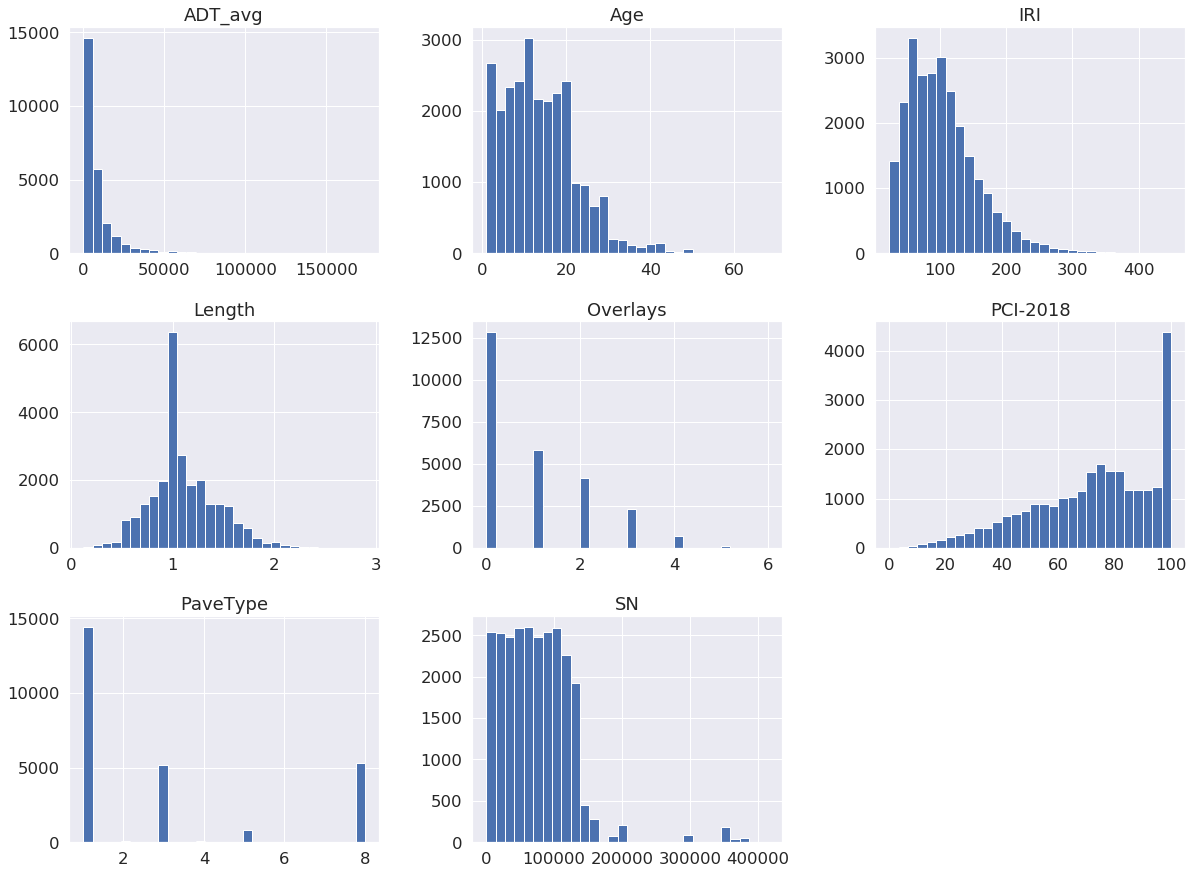

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
df_new.hist(bins=30, figsize=(20,15))
plt.show()

(array([  45.,  357.,  780., 1350., 2064., 2636., 3189., 4783., 3906.,
        6793.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

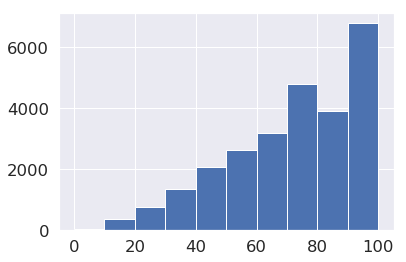

In [120]:
plt.hist(df_new["PCI-2018"])

(array([7.043e+03, 8.501e+03, 5.945e+03, 2.714e+03, 1.055e+03, 4.040e+02,
        1.500e+02, 7.400e+01, 1.300e+01, 4.000e+00]),
 array([ 23. ,  65.6, 108.2, 150.8, 193.4, 236. , 278.6, 321.2, 363.8,
        406.4, 449. ]),
 <a list of 10 Patch objects>)

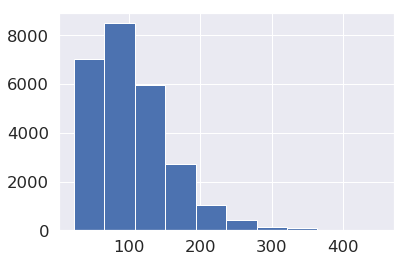

In [121]:
plt.hist(df_new["IRI"])

Develop a correlation matrix and plot it to find out what the data looks like when paired with the higest correlated variables.

In [122]:
corr_matrix = df_new.corr()
corr_matrix["PCI-2018"].sort_values(ascending=False)

PCI-2018    1.000000
PaveType    0.460876
ADT_avg     0.189583
SN          0.107303
Length      0.008240
Overlays   -0.061037
IRI        -0.512223
Age        -0.521708
Name: PCI-2018, dtype: float64

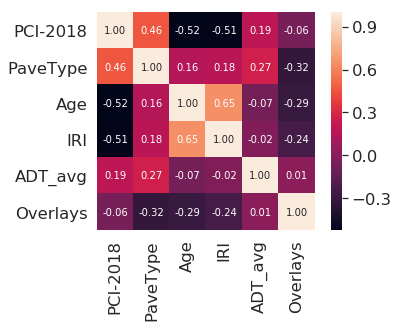

In [123]:
import numpy as np
attributes = ['PCI-2018','PaveType','Age','IRI', 'ADT_avg', 'Overlays']
cm = np.corrcoef(df_new[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

Plot the top correlation plot, Age vs. PCI. 

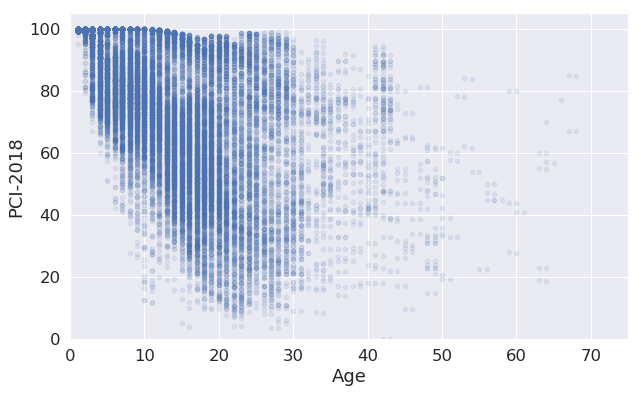

In [124]:
df_new.plot(kind="scatter", x='Age', y="PCI-2018", alpha=0.1,figsize=(10,6))
plt.axis([0,75, 0, 105])
plt.show()

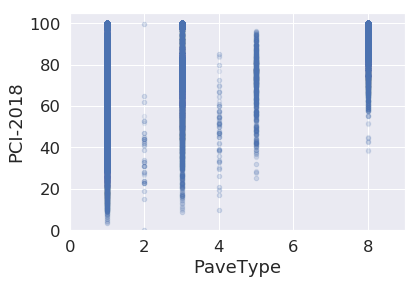

In [125]:
df_new.plot(kind="scatter", x='PaveType', y="PCI-2018", alpha=0.1,figsize=(6,4))
plt.axis([0,9, 0, 105])
plt.show()

## Break out each pavement type and complete statistics for each

In [126]:
df_new.PaveType.value_counts()

1    14442
8     5313
3     5178
5      800
4      104
2       66
Name: PaveType, dtype: int64

In [127]:
#Type 1's
#All Type 1's regardless of # overlays
Type1n = df_new[df_new.PaveType == 1]
#Type 1 with 0 overlays
Type1_0n = df_new[(df_new.PaveType == 1) & (df_new.Overlays == 0)]
#Type 1 with 1 overlays
Type1_1n = df_new[(df_new.PaveType == 1) & (df_new.Overlays == 1)]
#Type 1 with 2 overlays
Type1_2n = df_new[(df_new.PaveType == 1) & (df_new.Overlays == 2)]
#Type 1 with 3+ overlays
Type1_3n = df_new[(df_new.PaveType == 1) & (df_new.Overlays >= 3)]

#Type 2's
Type2n = df_new[df_new.PaveType == 2]
Type3n = df_new[df_new.PaveType == 3]
Type4n = df_new[df_new.PaveType == 4]
Type5n = df_new[df_new.PaveType == 5]
Type8n = df_new[df_new.PaveType == 8]

## Residual Plot of Each Pavement Type. 

The residplot() function can be a useful tool for checking whether the simple regression model is appropriate for a dataset. It fits and removes a simple linear regression and then plots the residual values for each observation. Ideally, these values should be randomly scattered around y = 0.
If there is structure in the residuals, it suggests that simple linear regression is not appropriate.

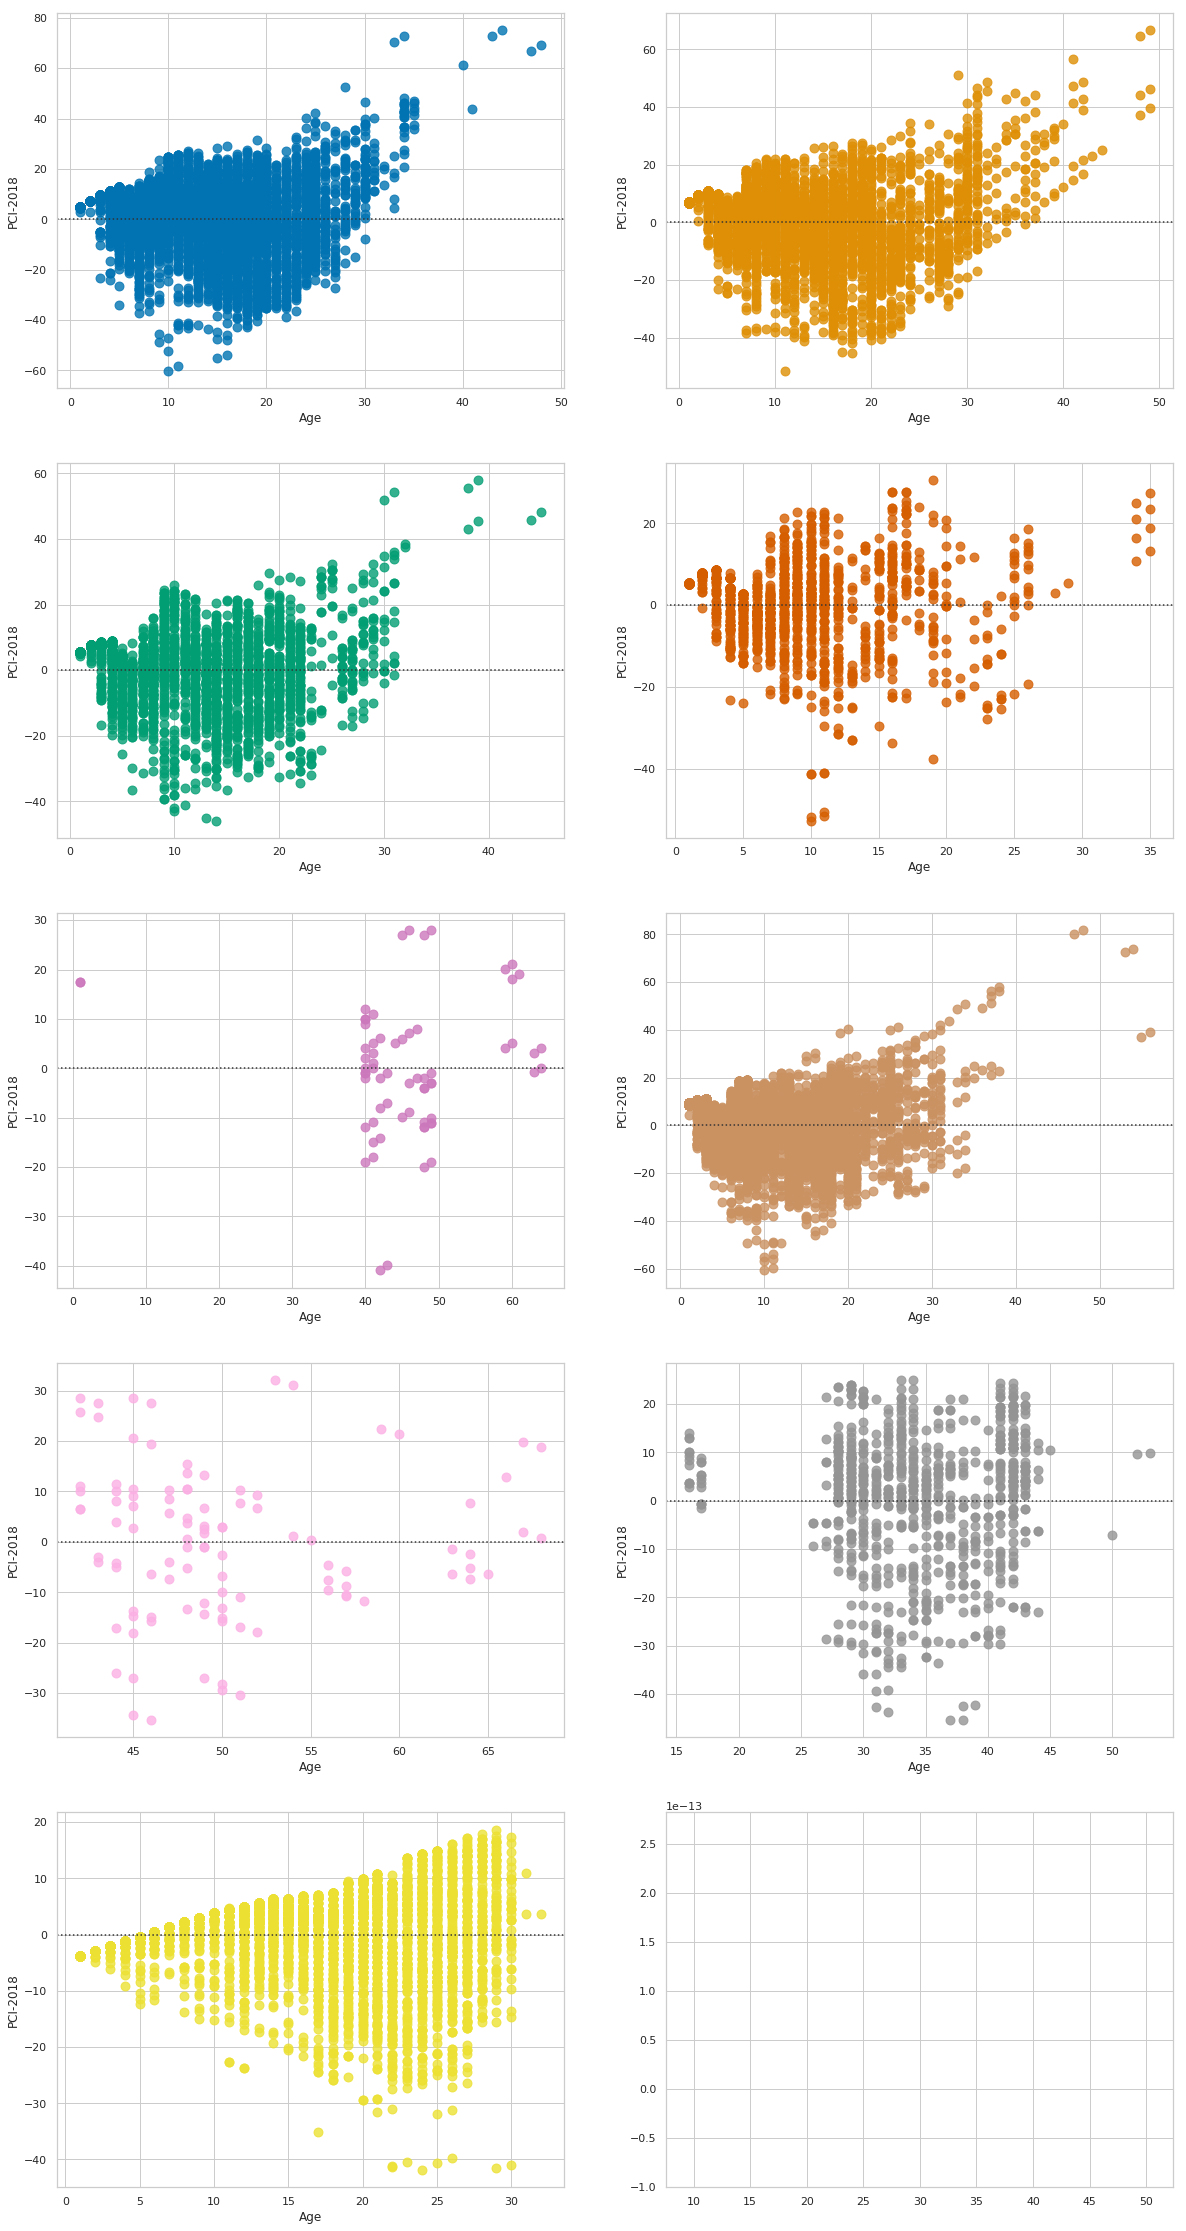

In [128]:
sns.set(style="whitegrid",palette="colorblind")
f, axes = plt.subplots(5,2, figsize=(20, 40), sharex=False)
sns.residplot(x="Age", y="PCI-2018", data=Type1_0n, scatter_kws={"s": 80},ax=axes[0,0])
sns.residplot(x="Age", y="PCI-2018", data=Type1_1n, scatter_kws={"s": 80},ax=axes[0,1])
sns.residplot(x="Age", y="PCI-2018", data=Type1_2n, scatter_kws={"s": 80},ax=axes[1,0])
sns.residplot(x="Age", y="PCI-2018", data=Type1_3n, scatter_kws={"s": 80},ax=axes[1,1])
sns.residplot(x="Age", y="PCI-2018", data=Type2n, scatter_kws={"s": 80},ax=axes[2,0])
sns.residplot(x="Age", y="PCI-2018", data=Type3n, scatter_kws={"s": 80},ax=axes[2,1])
sns.residplot(x="Age", y="PCI-2018", data=Type4n, scatter_kws={"s": 80},ax=axes[3,0])
sns.residplot(x="Age", y="PCI-2018", data=Type5n, scatter_kws={"s": 80},ax=axes[3,1]);
sns.residplot(x="Age", y="PCI-2018", data=Type8n, scatter_kws={"s": 80},ax=axes[4,0]);

## Scatterplot of all data with pave type by color and ADT by size

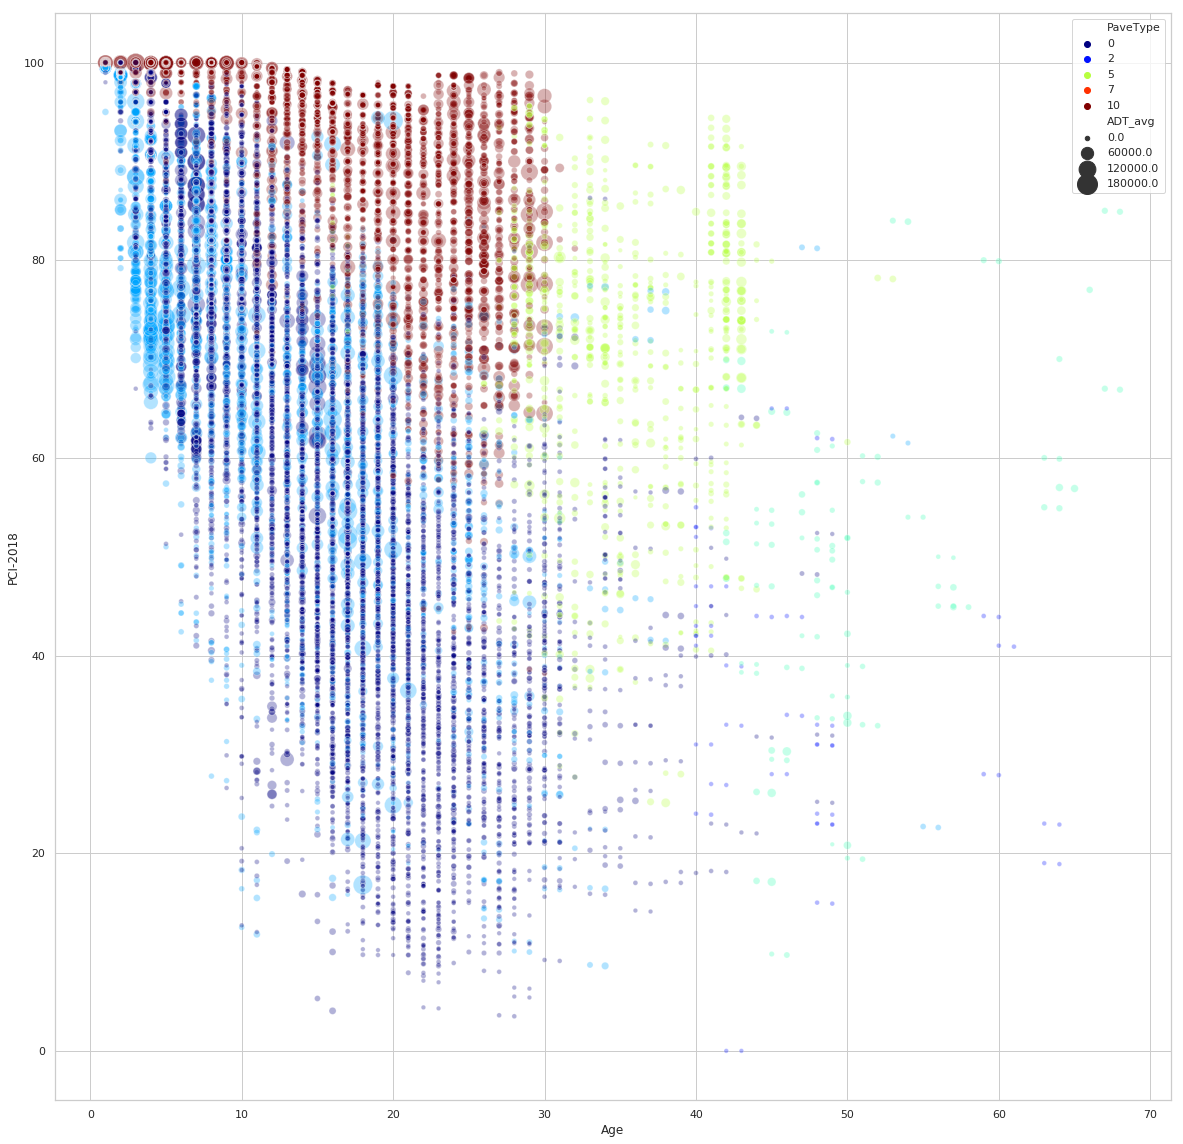

In [129]:
import seaborn as sns
sns.set(style="whitegrid")
f, axes = plt.subplots(1,1, figsize=(20, 20), sharex=False)
sns.scatterplot(x="Age", y="PCI-2018", hue="PaveType", size='ADT_avg', 
                palette="jet",alpha=.3,sizes=(20,400), data=df_new)

## Scatterplot of all data with pave type by plot and ADT by size

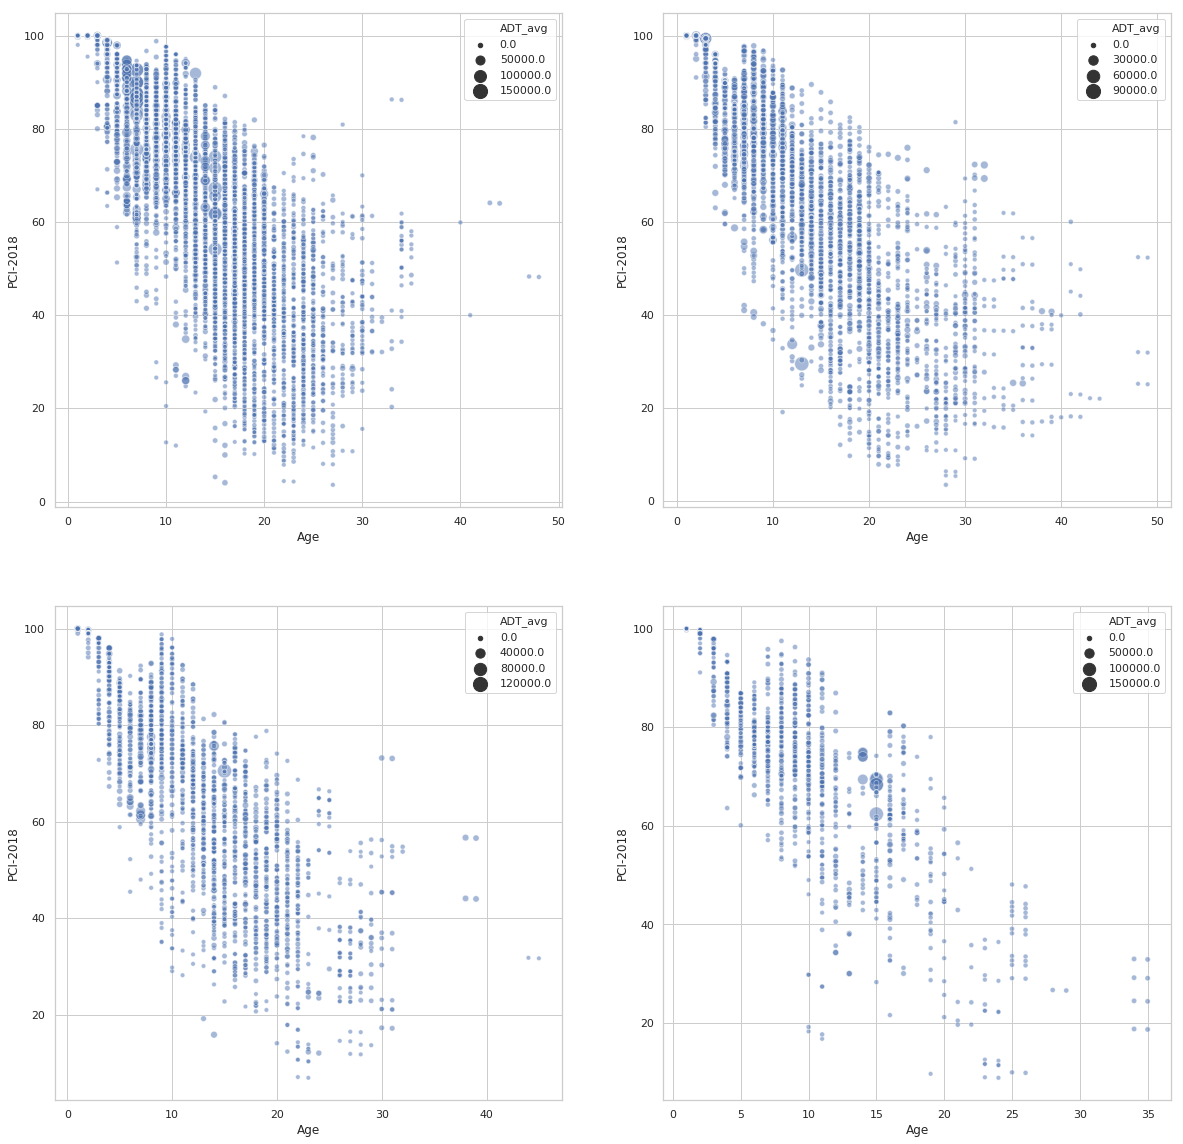

In [130]:
import seaborn as sns
sns.set(style="whitegrid")
f, axes = plt.subplots(2,2, figsize=(20, 20), sharex=False)
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_0n, ax=axes[0,0] )
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_1n, ax=axes[0,1])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_2n, ax=axes[1,0])
sns.scatterplot(x="Age", y="PCI-2018", size='ADT_avg', 
                palette="jet",alpha=.5,sizes=(20,200), data=Type1_3n, ax=axes[1,1])

## Swarmplot w/ Boxplot by Pave Type

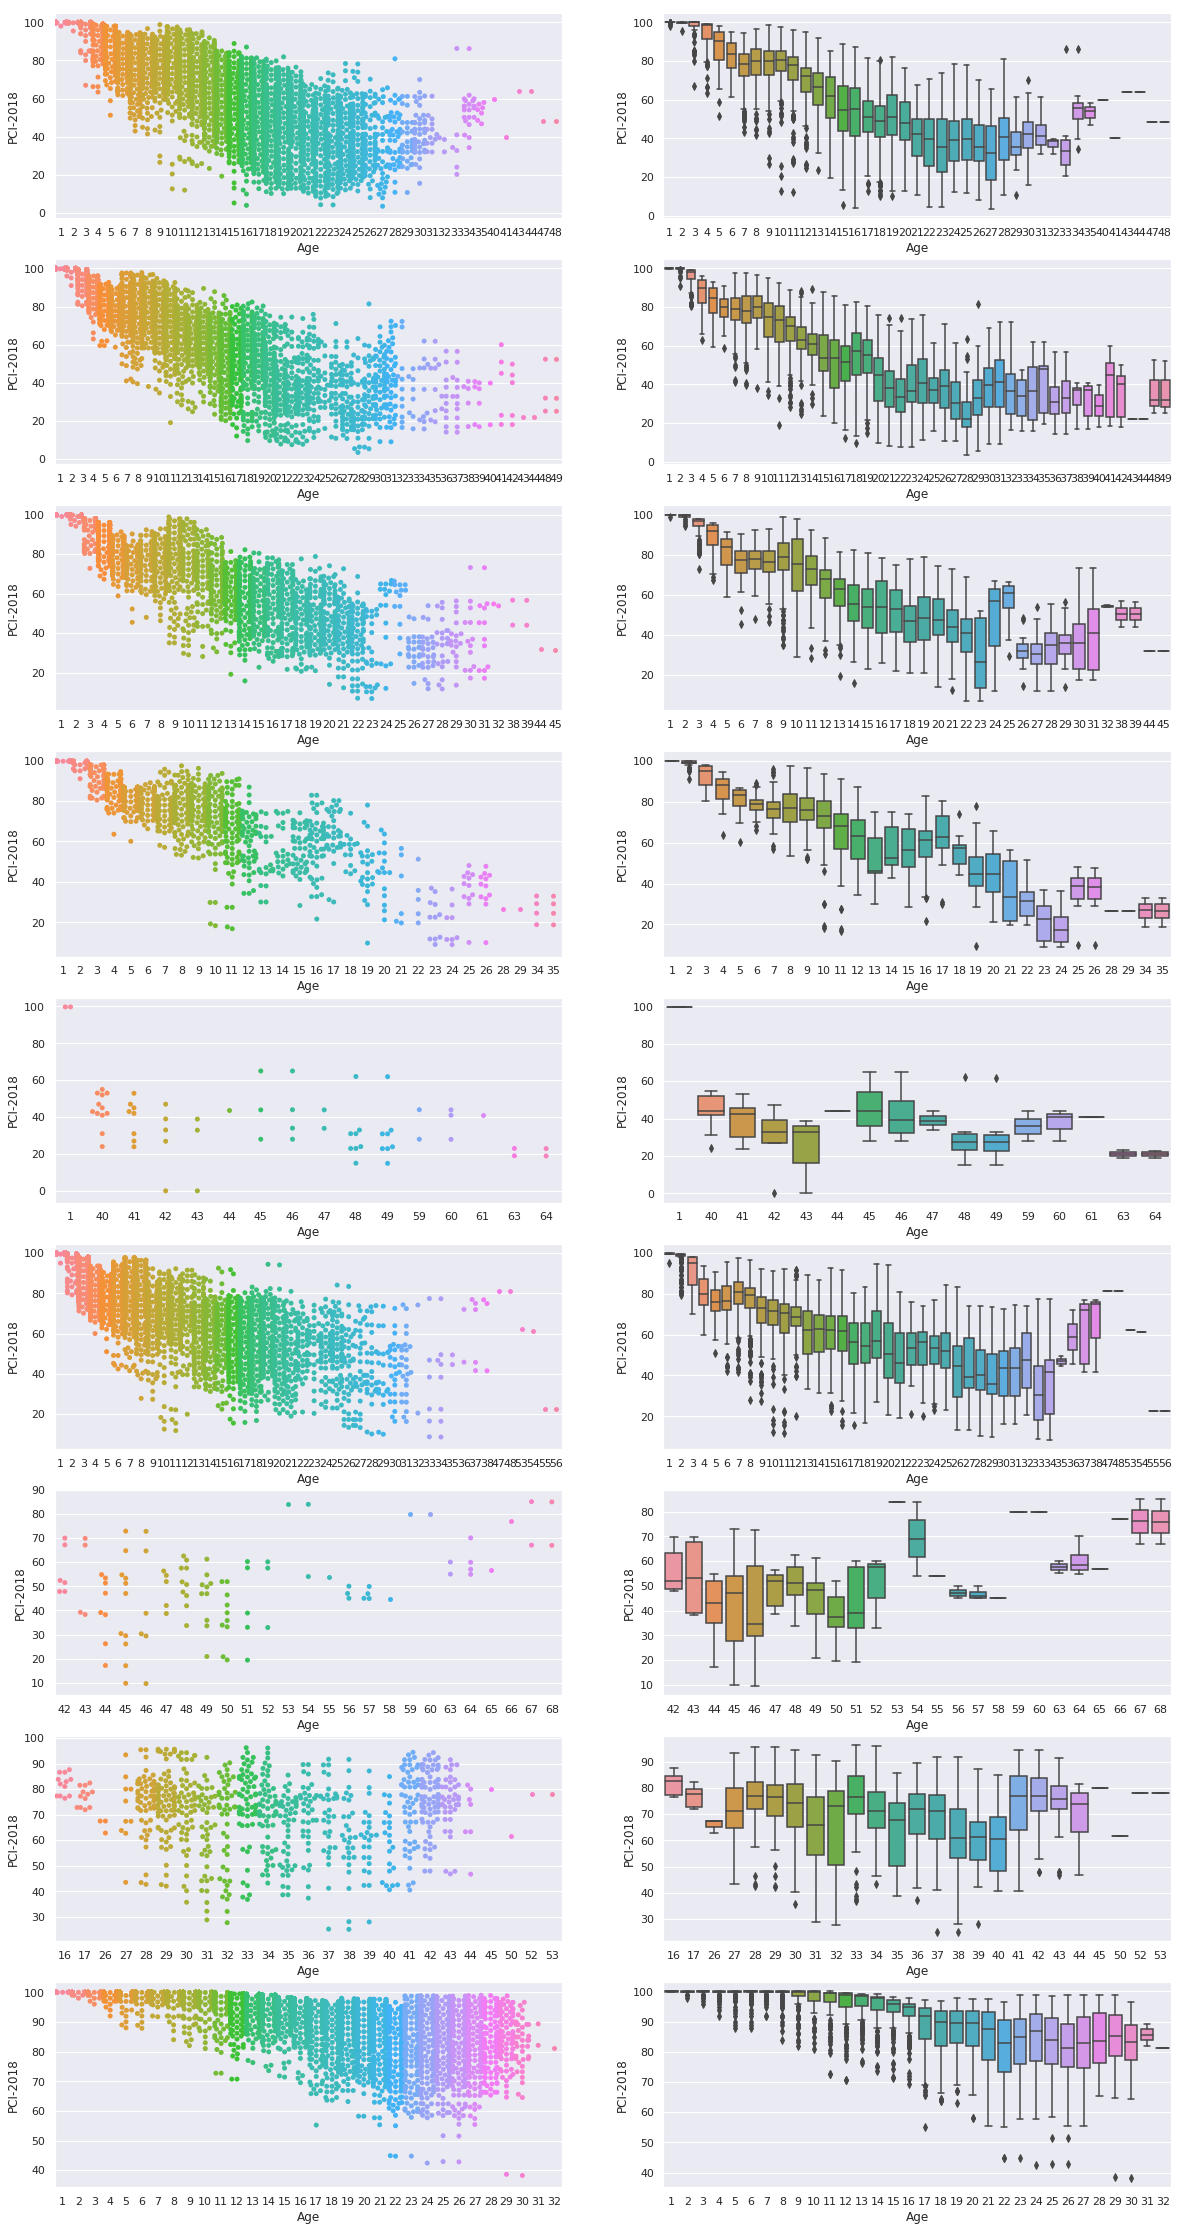

In [138]:
sns.set(style="darkgrid",palette="muted")
f, axes = plt.subplots(9,2, figsize=(20, 40), sharex=False)
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_0n, ax=axes[0,0], edgecolor="black")
sns.boxplot(x="Age", y="PCI-2018", data=Type1_0n, ax=axes[0,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_1n, ax=axes[1,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_1n, ax=axes[1,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_2n, ax=axes[2,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_2n, ax=axes[2,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type1_3n, ax=axes[3,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type1_3n, ax=axes[3,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type2n, ax=axes[4,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type2n, ax=axes[4,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type3n, ax=axes[5,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type3n, ax=axes[5,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type4n, ax=axes[6,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type4n, ax=axes[6,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type5n, ax=axes[7,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type5n, ax=axes[7,1])
sns.swarmplot(x="Age", y="PCI-2018", data=Type8n, ax=axes[8,0])
sns.boxplot(x="Age", y="PCI-2018", data=Type8n, ax=axes[8,1])

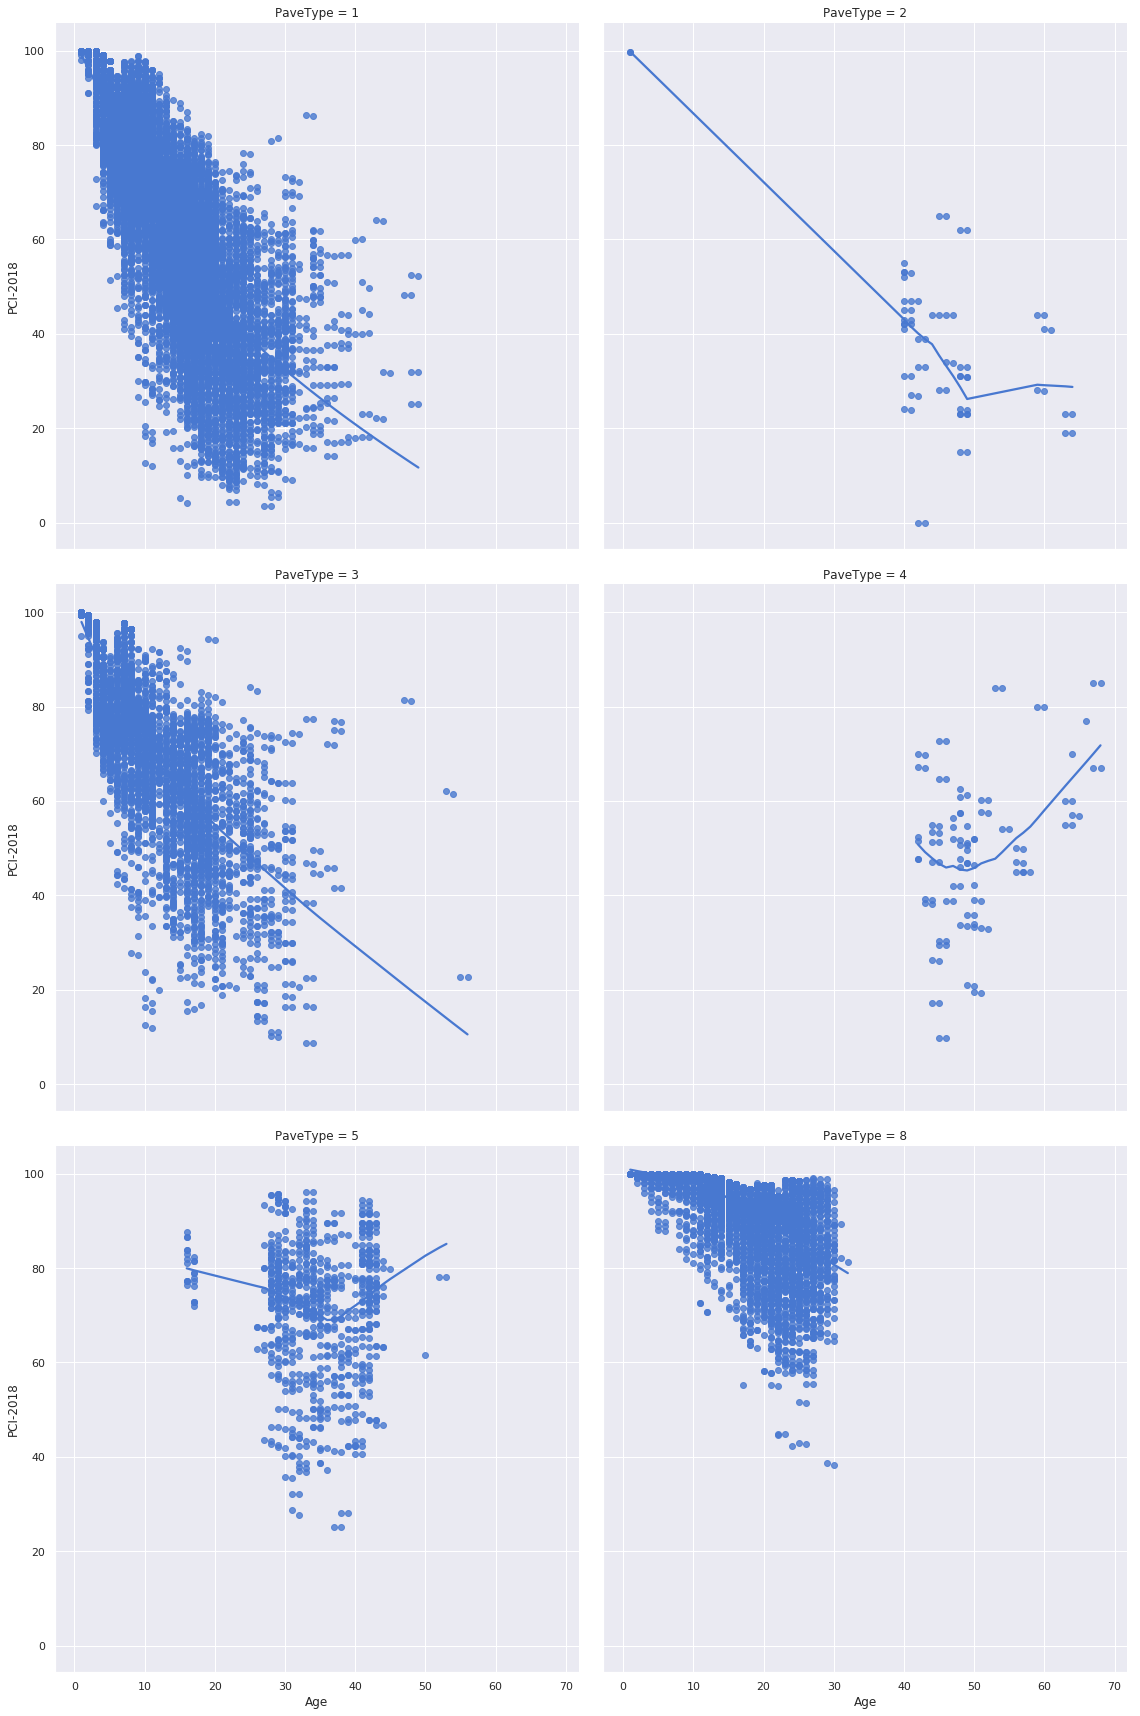

In [132]:
sns.lmplot(x="Age", y="PCI-2018", col="PaveType", data=df_new,lowess=True,truncate=True, 
           col_wrap=2, height=8);

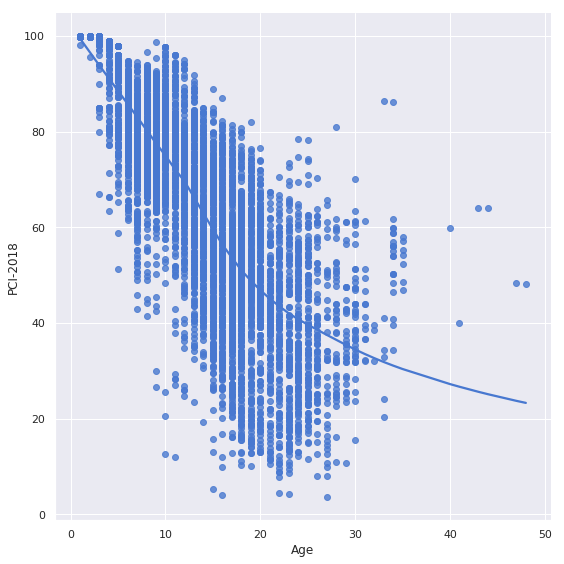

In [133]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_0n,
           lowess=True, height=8);

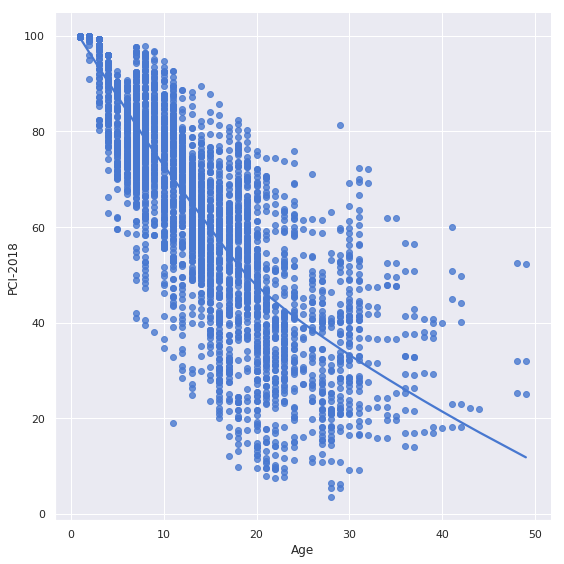

In [134]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_1n,
           lowess=True, height=8);

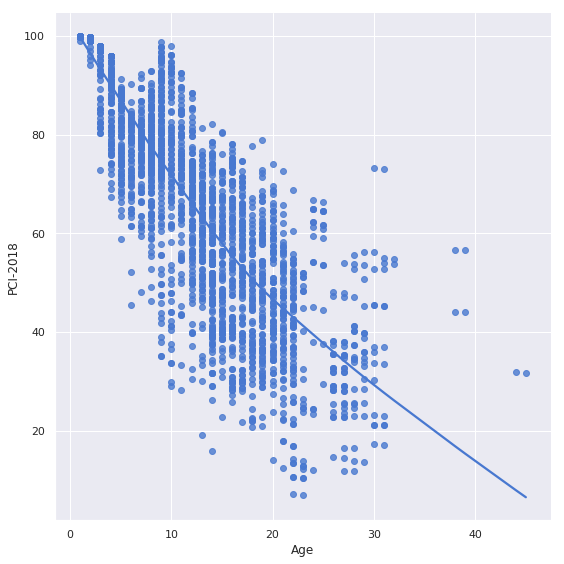

In [135]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_2n,
           lowess=True, height=8);

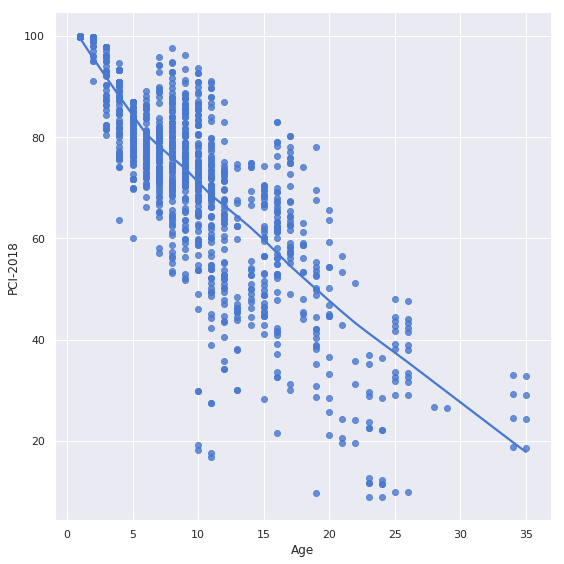

In [136]:
sns.lmplot(x="Age", y="PCI-2018", data=Type1_3n,
           lowess=True, height=8);

## Summary of Additional Data 
It appears that the additional dataset did not add any additional value to the basic models. It appears that over one year the majority of data did not change much. The 2017 data is basically a duplication of the 2018 data, shifted one year to the left in the plots.

# -----------------------------------------------------------------------------------------------------------

# Setting up Machine Learning Models 
## Training

## Pipeline Using Basic Features

In [21]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ['Age', 'ADT_avg']

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])

# Identify the categorical features we wish to consider.
cat_attribs = ['PaveType']

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore")),
        ])

# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline)])

## Train/Test Split

Reorder the data so it is easier to select subset of columns to use for train/test.

In [75]:
df1 = df1[['PCI-2018','PaveType','Age','ADT_avg']]

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [76]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = df1.iloc[:,1:]
y = df1['PCI-2018']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

X_train (9067, 3) y_train (9067,)
X_test (3886, 3) y_test (3886,)


# Baseline Linear Regression, SVR, Ridge

In [78]:
X_train = full_pipeline.fit_transform(X_train)
print(X_train.shape)

X_test = full_pipeline.transform(X_test)
print(X_test.shape)

(9067, 8)
(3886, 8)


In [79]:
print(X_train[0])

[ 0.56442395 -0.43413108  1.          0.          0.          0.
  0.          0.        ]


In [27]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train MSE","Train RMSE","Test MSE","Test RMSE","p-value", 
                                "Train Time(s)", "Test Time(s)", "Experiment description"])

## Baseline Linear Regression

In [28]:
# This Linear Regression model will serve as a baseline for comparison. 
# It will not be tuned, nor will it use crossfold validation.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit the training data
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict the outcomes
linreg_preds_train = linreg.predict(X_train)
linreg_preds = linreg.predict(X_test)

#MSE
mse_train = mean_squared_error(y_train, linreg_preds_train)
mse_test = mean_squared_error(y_test, linreg_preds)
print(linreg_preds)
print ('MSE train: %.3f, test: %.3f' % (
      mean_squared_error(y_train, linreg_preds_train),
      mean_squared_error(y_test, linreg_preds)))
print ('RMSE train: %.3f, test: %.3f' % (
      np.sqrt(mean_squared_error(y_train, linreg_preds_train)),
      np.sqrt(mean_squared_error(y_test, linreg_preds))))

[87.79081345 72.41138093 49.10923633 ... 84.02218909 57.39177012
 45.23709253]
MSE train: 174.286, test: 177.434
RMSE train: 13.202, test: 13.320


In [29]:
print(linreg.fit(X_train, y_train).intercept_)
print(linreg.fit(X_train, y_train).coef_)

92.47525188111646
[-17.19917785   0.4294587  -29.55828086   6.11559633 -27.12477262
  29.95046629  18.46624452   2.15074634]


In [38]:
# Use crossval to get array of differnt scores
# Predict the outcomes
linreg_preds_train = linreg.predict(X_train)
linreg_preds = linreg.predict(X_test)

cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
linreg_scores = cross_val_score(linreg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
linreg_testscores = cross_val_score(linreg, X_test, y_test, cv=cv, scoring='neg_mean_squared_error')

lr_score_train = linreg_scores.mean()
lr_score_test  = linreg_testscores.mean()

In [103]:
results.loc[0] = ["Linear Baseline", lr_score_train,np.sqrt(-lr_score_train),
                  lr_score_test, np.sqrt(-lr_score_test),
                  "---", "< 1s", "< 1s", "Untuned LinearRegression"]
results

ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0  Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   

  Train Time(s) Test Time(s)    Experiment description  
0          < 1s         < 1s  Untuned LinearRegression

The test Root mean squared error is about 13.3. This doesn't seem like a terrible result, but we are off by a large enough amount that we wouldn't be happy with the prediction. 

## Crossval SVR

In [104]:
from sklearn.svm import SVR

poly_kernel_svm_reg = SVR()
poly_kernel_svm_reg.fit(X_train, y_train)

# Predict the test outcomes
poly_kernel_svm_train = poly_kernel_svm_reg.predict(X_train)
poly_kernel_svm_preds = poly_kernel_svm_reg.predict(X_test)

cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
poly_kernel_svm_reg_scores = cross_val_score(poly_kernel_svm_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
poly_kernel_svm_reg_testscores = cross_val_score(poly_kernel_svm_reg, X_test, y_test, cv=cv, scoring='neg_mean_squared_error')

poly_score_train = poly_kernel_svm_reg_scores.mean()
poly_score_test  = poly_kernel_svm_reg_testscores.mean()

In [105]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, poly_kernel_svm_reg_scores)

In [106]:
results.loc[1] = ["SVR Crossval", -poly_score_train, np.sqrt(-poly_score_train),
                  -poly_score_test, np.sqrt(-poly_score_test),
                  round(p_value,3), "< 1s", "< 1s", "CV SupportVectorRegressor"]
results

ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0  Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   
1     SVR Crossval  133.049983   11.534729  144.054554  12.002273       0   

  Train Time(s) Test Time(s)     Experiment description  
0          < 1s         < 1s   Untuned LinearRegression  
1          < 1s         < 1s  CV SupportVectorRegressor

The support vector regressor with 30 fold crossvalidation gave us better scores for the train and test MSE. We see a RMSE of 12 on the test set. This also shows to be a significant improvement with a p-value = 0.00X.

## Crossval Ridge

In [166]:
from sklearn.linear_model import Ridge

# Fit the training data
ridgereg = Ridge()
ridgereg.fit(X_train, y_train)

# Predict the test outcomes
#ridgereg_preds_train = ridgereg.predict(X_train)
#ridgereg_preds = ridgereg.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
ridgereg_scores = cross_val_score(ridgereg, X_train, y_train, cv=cv,scoring='neg_mean_squared_error')
ridgereg_score_train = ridgereg_scores.mean()

ridgereg_scores_tst = cross_val_score(ridgereg, X_test, y_test, cv=cv,scoring='neg_mean_squared_error')
ridgereg_score_test = ridgereg_scores_tst.mean()

In [167]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, ridgereg_scores)

In [168]:
results.loc[2] = ["Ridge Crossval", -ridgereg_score_train,np.sqrt(-ridgereg_score_train),
                  -ridgereg_score_test, np.sqrt(-ridgereg_score_test),
                  round(p_value,3), "< 1s", "< 1s", "CV RidgeRegression"]
results

ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE  \
0         Linear Baseline -175.517803   13.248313 -177.421564  13.319969   
1            SVR Crossval  133.049983   11.534729  144.054554  12.002273   
2          Ridge Crossval  175.098095   13.232464  175.343641  13.241739   
3          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
4      Tuned RandomForest   98.203028    9.909744    0.817788   0.904316   
5             Tuned Ridge  174.815400   13.221778    0.644329   0.802701   
6               Tuned SGD  174.910964   13.225391   -0.644368   0.802726   
7               Tuned SVR  132.767096   11.522460   -0.731930   0.855529   
8  RandomSearch RndForest   98.449915    9.922193   -0.817465   0.904138   
9      RandomSearch Ridge  174.817774   13.221867   -0.644340   0.802708   

  p-value Train Time(s) Test Time(s)  \
0     ---          < 1s         < 1s   
1       0          < 1s         < 1s   
2   0.779          < 1s         < 1s   
3       0          < 1s         < 1s   
4       0          0.94         0.11   
5   0.689             0            0   
6   0.731          0.93            0   
7       0           5.4         1.32   
8       0          0.81         0.08   
9    0.69             0            0   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV RidgeRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...  
7  {'max_iter': -1, 'shrinking': True, 'tol': 0.0...  
8  {'criterion': 'mse', 'min_impurity_split': Non...  
9  {'max_iter': 861, 'solver': 'auto', 'copy_X': ...

The Crossvalidated Ridge regressor with 30 fold crossvalidation gave us a slightly better train and test RMSE. We see a RMSE of 13.24 on the test set. This is not a significant improvement with a p-value = 0.779.

## Crossval Lasso

In [110]:
from sklearn.linear_model import Lasso

# Fit the training data
lassoreg = Lasso()
lassoreg.fit(X_train, y_train)

# Predict the test outcomes
#ridgereg_preds_train = ridgereg.predict(X_train)
#ridgereg_preds = ridgereg.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
lassoreg_scores = cross_val_score(lassoreg, X_train, y_train, cv=cv,scoring='neg_mean_squared_error')
lassoreg_score_train = lassoreg_scores.mean()

lassoreg_scores_tst = cross_val_score(lassoreg, X_test, y_test, cv=cv,scoring='neg_mean_squared_error')
lassoreg_score_test = lassoreg_scores_tst.mean()

In [111]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, lassoreg_scores)

In [113]:
results.loc[3] = ["Lasso Crossval", -lassoreg_score_train,np.sqrt(-lassoreg_score_train),
                  -lassoreg_score_test, np.sqrt(-lassoreg_score_test),
                  round(p_value,3), "< 1s", "< 1s", "CV LassoRegression"]
results

ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0  Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   
1     SVR Crossval  133.049983   11.534729  144.054554  12.002273       0   
2   Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
3   Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   

  Train Time(s) Test Time(s)     Experiment description  
0          < 1s         < 1s   Untuned LinearRegression  
1          < 1s         < 1s  CV SupportVectorRegressor  
2          < 1s         < 1s         CV LassoRegression  
3          < 1s         < 1s         CV LassoRegression

The Crossvalidated Lasso regressor with 30 fold crossvalidation gave us a worse train and test RMSE. We see a RMSE of 15.11 on the test set. 

## Finetune model/pipeline hyperparameters

Let’s assume at this point that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that:

* GridSearch
* RandomSearch

### Finetune via GridSearch

In the following the `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
`n_estimators` and `max_features` hyperparameter values specified in the first dict
(don’t worry about what these hyperparameters mean for now; they will be explained
in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the `bootstrap` hyperparameter set to `False` instead of
`True` (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

#### GridSearch Random Forest

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from time import time

param_grid = [
    #try 12 (4×3) combinations with bootstrap set as False
    {'bootstrap': [True],'n_estimators': [85,90,95], 'max_features': [1,2]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+12)*5=120 rounds of training 
grid_search_rnd = GridSearchCV(forest_reg, param_grid, cv=2, scoring='neg_mean_squared_error')
grid_search_rnd.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_rnd.best_score_

# Best estimator fitting time
t0 = time()
grid_search_rnd.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t1 = time()
best_test_accuracy = grid_search_rnd.best_estimator_.score(X_test, y_test)
time_test = round(time() - t1,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
best_train_scores = cross_val_score(grid_search_rnd.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [122]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_rnd.best_estimator_.get_params()
print(best_parameters)

# Record the results
results.loc[4] = ["Tuned RandomForest", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, "Bootstrap Tuned RF"]
results

Best Parameters:
{'criterion': 'mse', 'min_impurity_split': None, 'min_weight_fraction_leaf': 0.0, 'bootstrap': True, 'random_state': 42, 'n_jobs': 1, 'max_depth': None, 'verbose': 0, 'max_features': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'warm_start': False, 'max_leaf_nodes': None, 'n_estimators': 95, 'oob_score': False, 'min_impurity_decrease': 0.0}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0     Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   
1        SVR Crossval  133.049983   11.534729  144.054554  12.002273       0   
2      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
3      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
4  Tuned RandomForest   98.203028    9.909744    0.817788   0.904316       0   

  Train Time(s) Test Time(s)     Experiment description  
0          < 1s         < 1s   Untuned LinearRegression  
1          < 1s         < 1s  CV SupportVectorRegressor  
2          < 1s         < 1s         CV LassoRegression  
3          < 1s         < 1s         CV LassoRegression  
4          0.94         0.11         Bootstrap Tuned RF

#### GridSearch Ridge Regression

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from time import time

param_grid = [
    # try 27 (3×3x3) combinations of hyperparameters
    {'alpha': ('0.50','0.75','0.9'), 'tol': (0.0, 0.5, 1.0),
     'max_iter': (1,2,4)}]

ridge_reg = Ridge(random_state=42)
# train across 5 folds, that's a total of (27)*5=135 rounds of training 
grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_ridge.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_ridge.best_score_

# Best estimator fitting time
t0 = time()
grid_search_ridge.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t1 = time()
best_test_accuracy = grid_search_ridge.best_estimator_.score(X_test, y_test)
time_test = round(time() - t1,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
best_train_scores = cross_val_score(grid_search_ridge.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [165]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_ridge.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[5] = ["Tuned Ridge", -best_train_accuracy, np.sqrt(-best_train_accuracy),
                  best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'max_iter': 1, 'solver': 'auto', 'copy_X': True, 'alpha': '0.9', 'tol': 0.0, 'normalize': False, 'fit_intercept': True, 'random_state': 42}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE  \
0         Linear Baseline -175.517803   13.248313 -177.421564  13.319969   
1            SVR Crossval  133.049983   11.534729  144.054554  12.002273   
2          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
3          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
4      Tuned RandomForest   98.203028    9.909744    0.817788   0.904316   
5             Tuned Ridge  174.815400   13.221778    0.644329   0.802701   
6               Tuned SGD  174.910964   13.225391   -0.644368   0.802726   
7               Tuned SVR  132.767096   11.522460   -0.731930   0.855529   
8  RandomSearch RndForest   98.449915    9.922193   -0.817465   0.904138   
9      RandomSearch Ridge  174.817774   13.221867   -0.644340   0.802708   

  p-value Train Time(s) Test Time(s)  \
0     ---          < 1s         < 1s   
1       0          < 1s         < 1s   
2       0          < 1s         < 1s   
3       0          < 1s         < 1s   
4       0          0.94         0.11   
5   0.689             0            0   
6   0.731          0.93            0   
7       0           5.4         1.32   
8       0          0.81         0.08   
9    0.69             0            0   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV LassoRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...  
7  {'max_iter': -1, 'shrinking': True, 'tol': 0.0...  
8  {'criterion': 'mse', 'min_impurity_split': Non...  
9  {'max_iter': 861, 'solver': 'auto', 'copy_X': ...

#### GridSearch Stochastic GD

In [ ]:
SGDRegressor.self.get_params().keys()

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from time import time

param_grid = [
    # try 36 (3×2x2X3) combinations of hyperparameters
    {'alpha': (.000075, 0.00005, 0.00001), 'penalty': ('l1', 'l2'),
     'loss': ('squared_loss', 'huber'),'max_iter': (100,200,300)}]          

SGD_reg = SGDRegressor(random_state=42)
# train across 5 folds, that's a total of (36)*5=180 rounds of training 
grid_search = GridSearchCV(SGD_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           refit='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search.best_score_

# Best estimator fitting time
t0 = time()
grid_search.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t1 = time()
best_test_accuracy = grid_search.best_estimator_.score(X_test, y_test)
time_test = round(time() - t1,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [156]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[6] = ["Tuned SGD", -best_train_accuracy, np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'max_iter': 300, 'verbose': 0, 'alpha': 1e-05, 'shuffle': True, 'power_t': 0.25, 'n_iter': None, 'learning_rate': 'invscaling', 'random_state': 42, 'loss': 'squared_loss', 'l1_ratio': 0.15, 'penalty': 'l1', 'warm_start': False, 'tol': None, 'epsilon': 0.1, 'eta0': 0.01, 'average': False, 'fit_intercept': True}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0     Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   
1        SVR Crossval  133.049983   11.534729  144.054554  12.002273       0   
2      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
3      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
4  Tuned RandomForest   98.203028    9.909744    0.817788   0.904316       0   
5         Tuned Ridge  174.815400   13.221778    0.644329   0.802701   0.689   
6           Tuned SGD  174.910964   13.225391   -0.644368   0.802726   0.731   

  Train Time(s) Test Time(s)  \
0          < 1s         < 1s   
1          < 1s         < 1s   
2          < 1s         < 1s   
3          < 1s         < 1s   
4          0.94         0.11   
5          0.01         0.01   
6          0.93            0   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV LassoRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...

#### GridSearch Support Vector Regressor

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from time import time

param_grid = [
    # try (3x2x4) combinations of hyperparameters
    {'tol': (0.01, 0.001, 0.001),'kernel': ('poly', 'rbf'),'degree': (1,2,3,4)}
]          

SV_reg = SVR()
# train across 5 folds, that's a total of (30)*5=150 rounds of training 
grid_search_svr = GridSearchCV(SV_reg, param_grid, cv=5, scoring='neg_mean_squared_error',refit='neg_mean_squared_error')

grid_search_svr.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_svr.best_score_

# Best estimator fitting time
t0 = time()
grid_search_svr.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = grid_search_svr.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
best_train_scores = cross_val_score(grid_search_svr.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [158]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_svr.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[7] = ["Tuned SVR", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy,np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'max_iter': -1, 'shrinking': True, 'tol': 0.01, 'epsilon': 0.1, 'verbose': False, 'coef0': 0.0, 'degree': 1, 'C': 1.0, 'gamma': 'auto', 'cache_size': 200, 'kernel': 'rbf'}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE p-value  \
0     Linear Baseline -175.517803   13.248313 -177.421564  13.319969     ---   
1        SVR Crossval  133.049983   11.534729  144.054554  12.002273       0   
2      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
3      Lasso Crossval  231.214161   15.205728  228.538065  15.117475       0   
4  Tuned RandomForest   98.203028    9.909744    0.817788   0.904316       0   
5         Tuned Ridge  174.815400   13.221778    0.644329   0.802701   0.689   
6           Tuned SGD  174.910964   13.225391   -0.644368   0.802726   0.731   
7           Tuned SVR  132.767096   11.522460   -0.731930   0.855529       0   

  Train Time(s) Test Time(s)  \
0          < 1s         < 1s   
1          < 1s         < 1s   
2          < 1s         < 1s   
3          < 1s         < 1s   
4          0.94         0.11   
5          0.01         0.01   
6          0.93            0   
7           5.4         1.32   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV LassoRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...  
7  {'max_iter': -1, 'shrinking': True, 'tol': 0.0...

### Finetune model using RandomizedSearchCV

In [159]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=50, high=150),
        'max_features': randint(low=1, high=4),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=15, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

# Best estimator score
best_train = rnd_search.best_score_

# Best estimator fitting time
t0 = time()
rnd_search.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t1 = time()
best_test_accuracy = rnd_search.best_estimator_.score(X_test, y_test)
time_test = round(time() - t1,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV

best_train_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

#### Random Search for 15 experiments

In [160]:
"""cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print(rnd_search.cv_best_estimator_)"""

# Collect the best parameters found by the random search
print("Best Parameters:")
best_parameters = rnd_search.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[8] = ["RandomSearch RndForest", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'criterion': 'mse', 'min_impurity_split': None, 'min_weight_fraction_leaf': 0.0, 'bootstrap': True, 'random_state': 42, 'n_jobs': 1, 'max_depth': None, 'verbose': 0, 'max_features': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'warm_start': False, 'max_leaf_nodes': None, 'n_estimators': 70, 'oob_score': False, 'min_impurity_decrease': 0.0}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE  \
0         Linear Baseline -175.517803   13.248313 -177.421564  13.319969   
1            SVR Crossval  133.049983   11.534729  144.054554  12.002273   
2          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
3          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
4      Tuned RandomForest   98.203028    9.909744    0.817788   0.904316   
5             Tuned Ridge  174.815400   13.221778    0.644329   0.802701   
6               Tuned SGD  174.910964   13.225391   -0.644368   0.802726   
7               Tuned SVR  132.767096   11.522460   -0.731930   0.855529   
8  RandomSearch RndForest   98.449915    9.922193   -0.817465   0.904138   

  p-value Train Time(s) Test Time(s)  \
0     ---          < 1s         < 1s   
1       0          < 1s         < 1s   
2       0          < 1s         < 1s   
3       0          < 1s         < 1s   
4       0          0.94         0.11   
5   0.689          0.01         0.01   
6   0.731          0.93            0   
7       0           5.4         1.32   
8       0          0.81         0.08   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV LassoRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...  
7  {'max_iter': -1, 'shrinking': True, 'tol': 0.0...  
8  {'criterion': 'mse', 'min_impurity_split': Non...

### Finetune Ridge model using RandomizedSearchCV

In [169]:
from sklearn.model_selection import RandomizedSearchCV
from random import randrange
from scipy.stats import randint

param_distribs = {
    'alpha': randint(-5,5),
    'max_iter': randint(low=1, high=5000),
    'tol': randint(low=1, high=10),
    }

ridge_reg = Ridge(random_state=42)
rnd_search_rr = RandomizedSearchCV(ridge_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_rr.fit(X_train, y_train)

# Best estimator score
best_train = rnd_search_rr.best_score_

# Best estimator fitting time
t0 = time()
rnd_search_rr.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t1 = time()
best_test_accuracy = rnd_search_rr.best_estimator_.score(X_test, y_test)
time_test = round(time() - t1,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(rnd_search_rr.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.710421e-17
  overwrite_a=True).T
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.710421e-17
  overwrite_a=True).T


#### Random Search for 20 experiments

In [170]:
"""cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)"""
    
# Collect the best parameters found by the random search
print("Best Parameters:")
best_parameters = rnd_search_rr.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[9] = ["RandomSearch Ridge", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'max_iter': 861, 'solver': 'auto', 'copy_X': True, 'alpha': 1, 'tol': 8, 'normalize': False, 'fit_intercept': True, 'random_state': 42}


ExpID   Train MSE  Train RMSE    Test MSE  Test RMSE  \
0         Linear Baseline -175.517803   13.248313 -177.421564  13.319969   
1            SVR Crossval  133.049983   11.534729  144.054554  12.002273   
2          Ridge Crossval  175.098095   13.232464  175.343641  13.241739   
3          Lasso Crossval  231.214161   15.205728  228.538065  15.117475   
4      Tuned RandomForest   98.203028    9.909744    0.817788   0.904316   
5             Tuned Ridge  174.815400   13.221778    0.644329   0.802701   
6               Tuned SGD  174.910964   13.225391   -0.644368   0.802726   
7               Tuned SVR  132.767096   11.522460   -0.731930   0.855529   
8  RandomSearch RndForest   98.449915    9.922193   -0.817465   0.904138   
9      RandomSearch Ridge  175.098095   13.232464   -0.644340   0.802708   

  p-value Train Time(s) Test Time(s)  \
0     ---          < 1s         < 1s   
1       0          < 1s         < 1s   
2   0.779          < 1s         < 1s   
3       0          < 1s         < 1s   
4       0          0.94         0.11   
5   0.689             0            0   
6   0.731          0.93            0   
7       0           5.4         1.32   
8       0          0.81         0.08   
9   0.779             0            0   

                              Experiment description  
0                           Untuned LinearRegression  
1                          CV SupportVectorRegressor  
2                                 CV RidgeRegression  
3                                 CV LassoRegression  
4                                 Bootstrap Tuned RF  
5  {'max_iter': 1, 'solver': 'auto', 'copy_X': Tr...  
6  {'max_iter': 300, 'verbose': 0, 'alpha': 1e-05...  
7  {'max_iter': -1, 'shrinking': True, 'tol': 0.0...  
8  {'criterion': 'mse', 'min_impurity_split': Non...  
9  {'max_iter': 861, 'solver': 'auto', 'copy_X': ...

## Plot the SVR vs Train Data

In [80]:
x_plot = [ x[0] for x in X_train]

In [81]:
X_train

array([[ 0.56442395, -0.43413108,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.56070124, -0.14573738,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11065117,  0.03326561,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.67321376,  0.52773373,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.67321376, -0.40926955,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22316369, -0.15623447,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

ValueError: x and y must have same first dimension, but have shapes (10, 1) and (9067,)

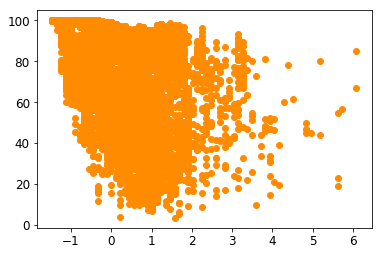

In [85]:
from sklearn.svm import SVR

"""#create classifier regression model
svr_rbf = SVR(kernel="rbf", C=1000, gamma=0.1)
svr_lin = SVR(kernel="linear", C=1000, gamma=0.1)
svr_poly = SVR(kernel="poly", C=1000, gamma=0.1)
"""

#use grid_sear3ch_svr from above
y_rbf = grid_search_svr.best_estimator_.predict(X_train)

"""#Fit regression model
y_rbf = svr_rbf.fit(x,y).predict(x)
y_lin = svr_lin.fit(x,y).predict(x)
y_poly = svr_poly.fit(x,y).predict(x)"""

X_train2 = np.resize(X_train,(len(X_train),1))

x_plot = np.resize(x_plot,(len(x_plot),1))
#Plotting of results
lw = 2
X_grid = np.arange(min(X_train2), max(X_train2), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(x_plot, y_train, color="darkorange", label="data")
plt.plot(X_grid, y_rbf, color="navy", lw=lw, label="RBF Model")
#plt.plot(x, y_lin, color="c", lw=lw, label="Linear Model")
#plt.plot(x, y_poly, color="cornflowerblue", lw=lw, label="Polynomial Model")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Support Vector Regression")
plt.legend()
plt.show()

## Observations

My observation is showing that the Best models are either the Crossvalidated Support Vector Regressor, Tuned Random Forest, Tuned SVR, or Random Search Random Forest. These models shows to be better than the baseline Linear Model with a high signficance value. 

The p-value is 0.000, which is below the standard thresholds of 0.05/2 or 0.01/2, so we can reject the null hypothesis and we can say that there is a statistically significant difference between the linear regression baseline and the four identified models. 

# Input variable importance  (this utilizes the random search - random forest regressor output)

Use the RandomForestRegressor to indicate the relative importance of each
attribute for making accurate predictions:

In [171]:
feature_importances = grid_search_rnd.best_estimator_.feature_importances_
feature_importances

array([0.52345257, 0.24532379, 0.07726942, 0.00266914, 0.02178282,
       0.00271384, 0.00577823, 0.12101018])

In [172]:
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs #+ extra_attribs 
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)

In [173]:
np.array(sortedFeatures)[:, 0]

array(['0.0026691424040651865', '0.0027138359296006516',
       '0.005778232261970119', '0.02178282319647047',
       '0.07726942469588934', '0.12101018157235434',
       '0.24532379443497945', '0.5234525655046706'], dtype='<U32')

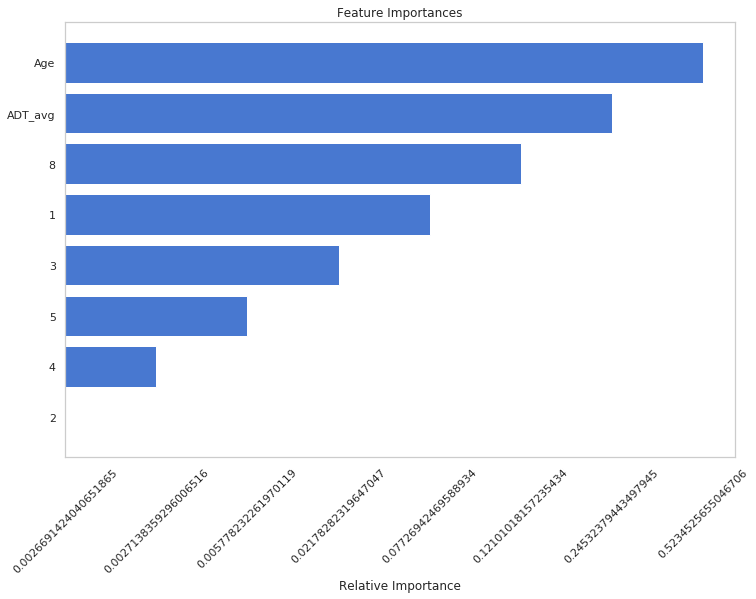

In [174]:
# Plot the feature importances of the forest model
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8)) 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.xticks(rotation=45)
plt.grid()
plt.show()

This plot shows us the the most important value in determining PCI is the Age of the Pavement. This is pretty obvious that, given age of pavement, there would be a correlation with PCI. The second most important factor is ADT_avg. This makes sense, especially on asphalt. 

## Feature Selection

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [175]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [187]:
k = 7

Now let's look for the indices of the top k features:

In [188]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([0, 1, 2, 4, 5, 6, 7])

In [189]:
np.array(attributes)[top_k_feature_indices]

array(['Age', 'ADT_avg', '1', '3', '4', '5', '8'], dtype='<U7')

Let's double check that these are indeed the top k features:

In [190]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.5234525655046706, 'Age'),
 (0.24532379443497945, 'ADT_avg'),
 (0.12101018157235434, 8),
 (0.07726942469588934, 1),
 (0.02178282319647047, 3),
 (0.005778232261970119, 5),
 (0.0027138359296006516, 4)]

Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [191]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [192]:
PCI_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X)


Let's look at the features of the first 3 instances:

In [194]:
PCI_prepared_top_k_features[0:7]


array([[-1.11874479,  0.34772132,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-1.4542465 ,  0.13680359,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-1.4542465 , -0.16511023,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 1.67710272,  0.5083941 ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 1.67710272,  0.47524909,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 1.67710272,  0.55380887,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 1.67710272,  0.73730007,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ]])

This output provides us information about the best features. The best feature appears to be Age.

##  Full pipeline for data prep, feature selection and modeling

In [195]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR()) #**rnd_search.best_params_
])

In [196]:
prepare_select_and_predict_pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Age', 'ADT_avg'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('std_scaler', S... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [197]:
np.set_printoptions(precision=3, suppress=True)

In [198]:
some_data = X.iloc[-100:]
some_labels = y.iloc[-100:]
pipe_prediction = prepare_select_and_predict_pipeline.predict(some_data)
original_label = list(some_labels)

np.column_stack((pipe_prediction,original_label))
#print("Predictions:\t", pipe_prediction)
#print("Labels:\t\t", original_label)

array([[100.046,  98.74 ],
       [ 82.15 ,  86.   ],
       [ 82.15 ,  88.7  ],
       [ 99.945,  99.97 ],
       [ 99.945,  99.97 ],
       [100.068,  98.74 ],
       [ 99.931,  99.97 ],
       [ 99.489,  99.97 ],
       [100.058,  98.74 ],
       [100.039,  99.97 ],
       [100.039,  99.97 ],
       [100.039,  99.97 ],
       [100.065,  99.97 ],
       [100.063,  96.74 ],
       [100.035,  97.74 ],
       [ 50.264,   8.6  ],
       [ 82.285,  72.4  ],
       [ 47.925,  68.3  ],
       [ 48.019,  63.1  ],
       [100.344,  99.95 ],
       [100.45 ,  99.95 ],
       [100.498,  99.95 ],
       [100.498,  99.95 ],
       [100.498,  98.85 ],
       [100.425,  93.85 ],
       [100.393,  99.95 ],
       [100.393,  99.95 ],
       [100.393,  89.86 ],
       [100.286,  99.95 ],
       [100.499,  99.95 ],
       [101.222,  99.93 ],
       [101.222,  99.93 ],
       [101.222,  99.93 ],
       [101.222,  99.93 ],
       [101.222,  99.93 ],
       [100.108, 100.   ],
       [100.108, 100.   ],
 

Well, the full pipeline does not seem to work. It would have worked better Utilizing the Ridge model as identified earlier.

## Use the full pipeline

Question: Automatically explore some preparation options using `GridSearchCV`.

In [199]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [1, 2, 3, 4, 5]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(X, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  19.4s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  19.4s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  19.7s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  2

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.3min


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  15.8s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  14.8s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  14.8

[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 10.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Age', 'ADT_avg'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('std_scaler', S... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [200]:
grid_search_prep.best_params_

{'feature_selection__k': 5,
 'preparation__num_pipeline__imputer__strategy': 'mean'}

It seems that we had the right imputer stragegy (mean), and apparently the top 5 features are useful (out of 27), the last 24 seem to just add some noise.

In [201]:
X.shape

(12953, 3)

# Extend baseline ML Pipeline - Stop Point as of 8/10

## More data is needed to build a better predicitive model.
I will add in some details about lane widts, shoulder widths, shoulder material, etc. Repeat all of the data manipulation that was done earlier

In [ ]:
Inventory="Intersection_Inventory.csv"
df1 = pd.read_csv(Inventory,low_memory=False)

In [ ]:
df1.head()

Adjust the skew angle so that it is all in terms of 0 to 90 degrees.

In [ ]:
df1.loc[df1['SKEW_ANGLE'] >= 90, 'SKEW_ANGLE'] = df1['SKEW_ANGLE']- 90
df1.loc[df1['SKEW_ANGLE'] == 90, 'SKEW_ANGLE'] = 0
df1.loc[df1['SKEW_ANGLE'] == -1, 'SKEW_ANGLE'] = 0

reduce number of median categores by dividing by 10.

In [ ]:
# Divide by 10 to limit the number of Median_FT values
df1["MEDIAN_FT"] = np.ceil(df1["MEDIAN_FT"] / 10)
# Label those above 10 as 10
df1["MEDIAN_FT"].where(df1["MEDIAN_FT"] < 10, 10.0, inplace=True)

Drop unnecssary information.

In [ ]:
df1.drop(['MAJOR_INDC','MAJOR_WID','MINOR_INDC','LIGHTING','COMMENTS',
          'MINOR_PDP','MINOR_WID','MAJOR_SRC','MINOR_SRC','MAJ_1_LTL','MINOR_ST',
          'MAJ_2_LTL','MAJ_2_RTL','MAJOR_ST','MAJ_1_RTL','COMMENTS.1', 'SIDE_CLASS']
         ,axis=1,inplace=True)
df1.drop([13891], axis=0, inplace=True)

In [ ]:
intx = 'combined_meta.csv'
# Load csv
cmet = pd.read_csv(intx,low_memory=False)

cmet = cmet.rename(index=str, columns={"PDP_ID":"MAJOR_PDP"}) 
new_data = pd.merge(df1, cmet, on='MAJOR_PDP', how='inner').copy()

In [ ]:
new_data.fillna(0,inplace=True)

In [ ]:
new_data.drop(['ISEQNO','TRAF_SEG_ID', 'RECKEY','FOS_PROJ_ID','PDP_FRM','PDP_TO',
               'PDP_MILE','ACSI_INTS_NM','HWY&DIR','PPROJ_GRP_DESC','FCLASS','NHS',
               'C2030','AADTYR_10','GFPYELOW','HCURLE40','HCURGT40', 'TERMINI', 'NUMLANES',
               'HWCMTYCD', 'HWFDURBC','WI_CNTY_NM','MEDNTYP', 'MEDNWD', 'MAINTYP',
               'AADTYR_1','MAJOR_PDP','DOR_CNTY_C','LEGCOUNT', 'RMP_TRMNL',"CONTROL","LEGS","ARTYP_FED","BYPASS_LN",
               "SHARED_LT","MEDIAN_TYP",'DIVUND'],
              axis=1, inplace=True)

In [ ]:
new_data.drop(new_data.columns[
    new_data.columns.str.contains('unnamed',case = False)],
              axis = 1,inplace=True)

### Check correlation matrix of this to see if there are additional columns that could be dropped.
Need to drop KAB ratio and Injury severity columns as they make up the KAB count.

Drop unnecssary information.

In [ ]:
new_data.drop(["INJSVR_K", "INJSVR_B","INJSVR_A","INJSVR_C","INJSVR_O"], axis=1,inplace=True)

In [ ]:
corr_matrix = new_data.corr()
corr_matrix["KAB_CRASH"].sort_values(ascending=False)

In [ ]:
from pandas.plotting import scatter_matrix
# Top six correlated inputs with KAB_CRASH, ignore other crash rates.
attributes = ['KAB_CRASH','CRSH_COUNT','MCOL_ANGL','MCOL_REAR',
              'MCOL_NO','CRSH_RT']
scatter_matrix(new_data[attributes], figsize=(15, 9))

In [ ]:
cm = np.corrcoef(new_data[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

Look at a plot of the most correlated features with KAB_CRASH.

In [ ]:
new_data.plot(kind="scatter", x='CRSH_COUNT', y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 55, 0, 7.5])
plt.show()

In [ ]:
new_data.plot(kind="scatter", x='MCOL_ANGL', y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 21, 0, 8])
plt.show()

## Modify previous Pipeline to inculde new features

In [ ]:
new_data.info()

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ["MIN_LNS","MAJ_LNS","MAJOR_AADT","MINOR_AADT",
               "TOTAL_AADT","CRSH_RT", "CRSH_COUNT","MCOL_ANGL","MCOL_REAR",
               "MCOL_NO", "MCOL_SSS", "MCOL_SSOP","MCOL_OTR", "LON", 
               "MEDIAN_FT", "SKEW_ANGLE", "LAT",'TRKYR_1','TRWAYWD',
               "RSHTOTWD","RSHPAVWD","RAUXWDTH","RAUX1TYP","RAUX1WD","RSH1WD","LAUXWDTH",
               "LAUX1TYP","LAUX1WD","LSHPAVWD","LSH1TYP","LSH1WD"]

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])

# Identify the categorical features we wish to consider.
#cat_attribs = ["CONTROL","LEGS","ARTYP_FED","BYPASS_LN",
              # "SHARED_LT","MEDIAN_TYP",'DIVUND']

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore")),
        ])

# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline)])

## Train/Test Split

Reorder the data so it is easier to select subset of columns to use for train/test.

In [ ]:
xset=new_data.drop(["KAB_CRASH"],axis=1).copy()

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [ ]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = xset.iloc[:,3:].copy()
y = new_data["KAB_CRASH"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [ ]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

In [ ]:
X_train_std = num_pipeline.fit_transform(X_train)
X_test_std = num_pipeline.fit_transform(X_test)

In [ ]:
X_train_std[0]

In [ ]:
X_test_std[0]

# Create a PCA model to find better results.

## PCA using scikitlearn

In [ ]:
from sklearn.decomposition import PCA

pca_loadings = pd.DataFrame(PCA().fit(X_train_std).components_.T,
                            index=X.columns, columns=["V1","V2","V3","V4","V5","V6",
                                                      "V7","V8","V9","V10", "V11",
                                                      "V12","V13","V14","V15","V16",
                                                      "V17", "V18",'V19','V20',"V21",
                                                      "V22","V23","V24","V25","V26",
                                                      "V27","V28","V29","V30","V31"]
                           )
pca_loadings

In [ ]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X_train_std), 
                       columns=['PC1', 'PC2', 'PC3','PC4','PC5','PC6',
                               'PC7', 'PC8', 'PC9','PC10','PC11','PC12',
                               'PC13', 'PC14', 'PC15','PC16','PC17','PC18',
                               'PC19', 'PC20', 'PC21','PC22','PC23','PC24',
                               'PC25', 'PC26', 'PC27','PC28','PC29','PC30',
                               'PC31'],index=X_train.index)
df_plot.head()

In [ ]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
#plot the loadings of the first PC and second PC (2 by 4 matrix)
ax2.set_xlabel('Principal Component loading vectors for PC1, and PC2 in 4Dimensions\nusing secondary x and y axis', color='red')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (-pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='red')

# Plot vectors
ax2.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V2[3])

In [ ]:
pca.explained_variance_

In [ ]:
pca.explained_variance_ratio_

We see that the first principal component explains 17% of the variance
in the data, the next principal component explains 15% of the variance,the next principal component explains 8% of the variance, the next principal component explains 8% of the variance,the next principal component explains 5% of the variance, and so forth. We can plot the PVE explained by each component as follows:

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
          23,24,25,26,27,28,29,30,31], pca.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31])

Look at the cumulative sum of the elements of the cumulative PVE.

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31])

However, none of this information really helps with this evaluation. It is nice to know, but since we are looking at coming up wiht a regression model, the results of this do not give us any additional insight.

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=6, 
                              random_state=42)
tree_reg.fit(X, y)

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Fit regression model
tree_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=5,random_state=42)
tree_reg1.fit(X_train, y_train)
tree_reg2.fit(X_train, y_train)

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_train, y_train)
tree_reg2.fit(X_train, y_train)

x1 = X_test
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg2,
        out_file="kab_tree2.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )
export_graphviz(
        tree_reg1,
        out_file="kab_tree1.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )

export_graphviz(
        tree_reg,
        out_file="kab_tree.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )

# Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(
    RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42))

# Best estimator fitting time
t0 = time()
bag_reg.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
ytr_pred_rf = bag_reg.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred_rf = bag_reg.predict(X_test_std)
time_test = round(time() - t0,2)

In [ ]:
rf_test_score = mean_squared_error(y_test, y_pred_rf)
rf_train_score = mean_squared_error(y_train, ytr_pred_rf)
rf_train_score

In [ ]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores, rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = bag_reg.get_params()
print(best_parameters)

# Record the results
results.loc[9] = ["Bagged RandomForest", rf_train_score, np.sqrt(rf_train_score),
                  rf_test_score, np.sqrt(rf_test_score), #round(p_value,3),
                  "---", time_train, time_test, best_parameters]
results

This Bagged RandomForest Model gave us much better results going to 0.43707 RMSE on the test set.

In [ ]:
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

# Best estimator fitting time
t0 = time()
bag_reg.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
ytr_pred_dt = bag_reg.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred_dt = bag_reg.predict(X_test_std)
time_test = round(time() - t0,2)

In [ ]:
rf_test_score = mean_squared_error(y_test, y_pred_dt)
rf_train_score = mean_squared_error(y_train, ytr_pred_dt)

In [ ]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = bag_reg.get_params()
print(best_parameters)

# Record the results
results.loc[10] = ["Bagged Decision Tree", rf_train_score, np.sqrt(rf_train_score),
                   rf_test_score, np.sqrt(rf_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

This Bagged Decision Tree Model gave us slightly better results of 0.434 RMSE on the test set, just slightly better than that of the Bagged Random Forest above.

The predictions were within .02% of one another.

In [ ]:
np.sum(abs(y_pred_dt - y_pred_rf)<0.20) / len(y_pred_dt)  # almost identical predictions

# Gradient Boosting 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train_std, y_train)

** Now train a second DecisionTreeRegressor on the residual errors made by the first
predictor:**

In [ ]:
y2_train = y_train - tree_reg1.predict(X_train_std)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X_train_std, y2_train)

** Now train a third DecisionTreeRegressor on the residual errors made by the first
predictor:**

In [ ]:
y3_train = y2_train - tree_reg2.predict(X_train_std)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X_train_std, y3_train)

In [ ]:
y_pred = sum(tree.predict(X_test_std) for tree in (tree_reg1, tree_reg2, tree_reg3))

### Prediction using GBDT model
Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [ ]:
y_pred

Calculate Mean Squared Error on prediction vs. test

In [ ]:
error = mean_squared_error(y_test, y_pred)
error

In [ ]:
# Record the results
results.loc[11] = ["GradientBoost Decision Tree", "---", error, 
                   "---", np.sqrt(error),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

### Gradient Boosting via Scikit-Learn

#### Fast

In [ ]:
xset=new_data.drop(["KAB_CRASH"],axis=1).copy()

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [ ]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = xset.iloc[:,3:].copy()
y = new_data["KAB_CRASH"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [ ]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

In [ ]:
X_train_std = num_pipeline.fit_transform(X_train)
X_test_std = num_pipeline.fit_transform(X_test)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
# Best estimator fitting time
t0 = time()
gbrt.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
gbrt_tr_pred = gbrt.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred = gbrt.predict(X_test_std)
time_test = round(time() - t0,2)

In [ ]:
gbrt_test_score = mean_squared_error(y_test, y_pred)
gbrt_train_score = mean_squared_error(y_train, gbrt_tr_pred)

In [ ]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = gbrt.get_params()
print(best_parameters)

# Record the results
results.loc[12] = ["Grad Boost Regressor Fast", gbrt_train_score, np.sqrt(gbrt_train_score),
                   gbrt_test_score, np.sqrt(gbrt_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

In [ ]:
X_train_std

#### Slow

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=3, n_estimators=200, learning_rate=0.1, random_state=42)

# Best estimator fitting time
t0 = time()
gbrt_slow.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
gbrt_tr_pred = gbrt_slow.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred = gbrt_slow.predict(X_test_std)
time_test = round(time() - t0,2)

In [ ]:
gbrt_test_score = mean_squared_error(y_test, y_pred)
gbrt_train_score = mean_squared_error(y_train, gbrt_tr_pred)

In [ ]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = gbrt_slow.get_params()
print(best_parameters)

# Record the results
results.loc[13] = ["Grad Boost Regressor Slow", gbrt_train_score, np.sqrt(gbrt_train_score),
                   gbrt_test_score, np.sqrt(gbrt_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results